In [1]:
import mne
import numpy as np
from scipy.signal import butter
import torch
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
from torchsummary import summary
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import scipy

# Load and view Train_Data

In [2]:
# data_path = ['A0'+str(i)+j for i in range(1,10) for j in ['T','E']]
data_path = ['A0'+str(i)+j for i in range(1,10) for j in ['T']]
raw = [mne.io.read_raw_gdf('2a/'+path+'.gdf',stim_channel="auto", verbose='ERROR',exclude=(["EOG-left", "EOG-central", "EOG-right"])) for path in data_path]
for i in range(len(raw)):
    raw[i].rename_channels({'EEG-Fz': 'Fz', 'EEG-0': 'FC3', 'EEG-1': 'FC1', 'EEG-2': 'FCz', 'EEG-3': 'FC2', 
                            'EEG-4': 'FC4','EEG-5': 'C5', 'EEG-C3': 'C3', 'EEG-6': 'C1', 'EEG-Cz': 'Cz', 
                            'EEG-7': 'C2', 'EEG-C4': 'C4', 'EEG-8': 'C6','EEG-9': 'CP3', 'EEG-10': 'CP1', 
                            'EEG-11': 'CPz', 'EEG-12': 'CP2', 'EEG-13': 'CP4','EEG-14': 'P1', 'EEG-15': 'Pz', 
                            'EEG-16': 'P2', 'EEG-Pz': 'POz'})


In [3]:
print(raw[3].get_data().shape)
events, event_id = mne.events_from_annotations(raw[3])
print(event_id)

(22, 600915)
Used Annotations descriptions: ['1023', '1072', '32766', '768', '769', '770', '771', '772']
{'1023': 1, '1072': 2, '32766': 3, '768': 4, '769': 5, '770': 6, '771': 7, '772': 8}


In [4]:
print(raw[0].info)
print(raw[3].info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2005-01-17 12:00:00 UTC
 nchan: 22
 projs: []
 sfreq: 250.0 Hz
 subject_info: 4 items (dict)
>
<Info | 8 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2004-11-08 12:00:00 UTC
 nchan: 22
 projs: []
 sfreq: 250.0 Hz
 subject_info: 4 items (dict)
>


# Train_Data preprocessing

In [5]:
for i in range(len(raw)):
    print(raw[i].get_data().shape)
    event, eventid = mne.events_from_annotations(raw[i])
    count = np.sum((event[:,2] - 7) >= 0)
    print(eventid)

(22, 672528)
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
(22, 677169)
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
(22, 660530)
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}
(22, 600915)
Used Annotations descriptions: ['1023', '1072', '32766', '768', '769', '770', '771', '772']
{'1023': 1, '1072': 2, '32766': 3, '768': 4, '769': 5, '770': 6, '771': 7, '772': 8}
(22, 686120)
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
{'1023': 1, '107

In [6]:
# specially for 4th sub
events = []
event_ids = []
for i in range(len(raw)):
    event_to_id = dict({'769':7,'770':8,'771':9,'772':10}) # Cue on left/right/foot/tongue
    if i==3:
        event_to_id = dict({'769':5,'770':6,'771':7,'772':8}) # Cue on left/right/foot/tongue
        event, _ = mne.events_from_annotations(raw[i])
        events.append(event)
        ids = np.unique(events[i][:, 2])
        event_id = {k: v for k, v in event_to_id.items() if v in ids}
        event_ids.append(event_id)
        print(event)
        print(event_id)
        raw[i].load_data()
        data = raw[i].get_data()
    else:
        event, _ = mne.events_from_annotations(raw[i])
        events.append(event)
        ids = np.unique(events[i][:, 2])
        event_id = {k: v for k, v in event_to_id.items() if v in ids}
        event_ids.append(event_id)
        print(event)
        print(event_id)
        raw[i].load_data()
        data = raw[i].get_data()
    for i_chan in range(data.shape[0]):  # go through 22 channel
        # set min to mean
        chan = data[i_chan]
        data[i_chan] = np.where(chan == np.min(chan), np.nan, chan)
        mask = np.isnan(data[i_chan])
        chan_mean = np.nanmean(data[i_chan])
        data[i_chan, mask] = chan_mean
    raw[i] = mne.io.RawArray(data, raw[i].info, verbose="ERROR")

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
[[     0      0      5]
 [     0      0      3]
 [ 29683      0      5]
 ...
 [670550      0      6]
 [670550      0      1]
 [671050      0      7]]
{'769': 7, '770': 8, '771': 9, '772': 10}
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
[[     0      0      5]
 [     0      0      3]
 [ 31513      0      5]
 ...
 [673632      0      7]
 [675191      0      6]
 [675691      0      9]]
{'769': 7, '770': 8, '771': 9, '772': 10}
Reading 0 ... 677168  =      0.000 ...  2708.672 secs...
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
[[     0      0      5]
 [     0      0      3]
 [ 23720      0      5]
 ...
 [656993      0      7]
 [658552      0      6]
 [659052      0      9]]
{'769': 7, '770': 8, '771': 9, '77

## Plot Before filter

In [7]:
# for i in range(len(raw)):
#     raw[i].plot(duration=5,n_channels=22,clipping=None)

In [8]:
%matplotlib inline

In [9]:
# # # for i in range(len(raw)):
# #     # psd_plot = raw[i].compute_psd().plot(average=True)

# psd_plot = raw[0].compute_psd().plot(average=True)

## Filter

In [10]:

tmin,tmax=-0.5,4 # tmin-tmax s after the event

for i in range(len(raw)):
    # IIR filter
    iir_params = dict(order=6, ftype='butter')
    raw[i].filter(l_freq=7., h_freq=37., method='iir', iir_params=iir_params) # 7-37 / 3-50
    # raw[i].filter(7.,47.,fir_design='firwin')
    epochs = mne.Epochs(raw[i],events[i],event_ids[i],tmin,tmax,proj=True,baseline=None,preload=True)
    labelsfile = scipy.io.loadmat('2a_label/'+data_path[i]+'.mat')
    labels = labelsfile['classlabel'].reshape(288)
    epochs_data = epochs.get_data()
#     data = epochs_data[:,:,:-1]
#     BCI_IV_2a_data = np.save(data_path[i][:-5]+'.npy',data)
    np.savez('2a_pre/'+data_path[i]+'.npz', data=epochs_data[:,:,:-1], label=labels)
    print(labels)
    print(epochs_data[:,:,:-1].shape)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 37 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 7.00, 37.00 Hz: -6.02, -6.02 dB

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
0 bad epochs dropped
[4 3 2 1 1 2 3 4 2 3 1 1 1 4 2 2 1 1 3 1 2 4 4 3 1 4 4 2 4 4 2 1 2 3 3 3 4
 3 1 4 2 3 2 3 4 2 3 1 1 1 4 2 1 3 1 3 2 4 1 3 3 1 3 2 4 4 4 3 1 4 2 4 2 1
 3 2 1 3 3 1 3 4 4 2 1 2 4 2 4 3 2 2 2 3 4 1 2 4 1 3 3 4 1 1 3 2 4 4 4 2 1
 3 2 4 1 4 3 2 4 4 1 2 2 3 4 2 1 1 4 2 1 3 2 2 3 1 4 3 3 3 3 1 2 1 2 1 1 3
 3 2 3 4 1 4 1 1 2 4 3 2 4 3 4 3 4 2 2 4 1 2 2 2 3 4 1 4 1 3 1 4 1 3 1 2 3
 3 4 1 2 4 2 3 3 1 4 2 4 1 1 3 3 2 4 2 2 1 2 4 4 2 2 2 2 4 4 3 4 1 2 3 2 1
 4 1 4 1 1 1 1 3 3 4 2 3 3 3 4

In [11]:
labels.shape

(288,)

## Plot After filter

In [12]:
# for i in range(len(raw)):
#     raw[i].plot(duration=5,n_channels=22,clipping=None)

In [13]:
%matplotlib inline

In [14]:
# # # for i in range(len(raw)):
# #     # psd_plot = raw[i].compute_psd().plot(average=True)

# psd_plot = raw[0].compute_psd().plot(average=True)

# Load and view Val_Data

In [15]:
# data_path = ['A0'+str(i)+j for i in range(1,10) for j in ['T','E']]
data_path = ['A0'+str(i)+j for i in range(1,10) for j in ['E']]
raw = [mne.io.read_raw_gdf('2a/'+path+'.gdf',stim_channel="auto", verbose='ERROR',exclude=(["EOG-left", "EOG-central", "EOG-right"])) for path in data_path]
for i in range(len(raw)):
    raw[i].rename_channels({'EEG-Fz': 'Fz', 'EEG-0': 'FC3', 'EEG-1': 'FC1', 'EEG-2': 'FCz', 'EEG-3': 'FC2', 
                            'EEG-4': 'FC4','EEG-5': 'C5', 'EEG-C3': 'C3', 'EEG-6': 'C1', 'EEG-Cz': 'Cz', 
                            'EEG-7': 'C2', 'EEG-C4': 'C4', 'EEG-8': 'C6','EEG-9': 'CP3', 'EEG-10': 'CP1', 
                            'EEG-11': 'CPz', 'EEG-12': 'CP2', 'EEG-13': 'CP4','EEG-14': 'P1', 'EEG-15': 'Pz', 
                            'EEG-16': 'P2', 'EEG-Pz': 'POz'})
data_path

['A01E', 'A02E', 'A03E', 'A04E', 'A05E', 'A06E', 'A07E', 'A08E', 'A09E']

In [16]:
print(raw[1].get_data().shape)
events, event_id = mne.events_from_annotations(raw[1])
print(event_id)

(22, 662666)
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '783': 7}


In [17]:
print(raw[0].info)
events, event_id

<Info | 8 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2005-01-19 12:00:00 UTC
 nchan: 22
 projs: []
 sfreq: 250.0 Hz
 subject_info: 4 items (dict)
>


(array([[     0,      0,      5],
        [     0,      0,      3],
        [ 22901,      0,      5],
        ...,
        [659129,      0,      7],
        [660688,      0,      6],
        [661188,      0,      7]]),
 {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '783': 7})

# Val_Data preprocessing

In [18]:
for i in range(len(raw)):
    print(raw[i].get_data().shape)
    event, eventid = mne.events_from_annotations(raw[i])
    count = np.sum((event[:,2] - 7) >= 0)
    print(eventid)
    print(count)

(22, 687000)
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '783': 7}
288
(22, 662666)
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '783': 7}
288
(22, 648775)
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '783': 7}
288
(22, 660047)
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '783': 7}
288
(22, 679863)
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '783': 7}
288
(22, 666373)
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
{'1023': 1, '1072

In [19]:
event_to_id = dict({'783':7}) # Cue on left/right/foot/tongue
events = []
event_ids = []
for i in range(len(raw)):
    event, _ = mne.events_from_annotations(raw[i])
    events.append(event)
    ids = np.unique(events[i][:, 2])
    event_id = {k: v for k, v in event_to_id.items() if v in ids}
    event_ids.append(event_id)
    print(event)
    print(event_id)
    raw[i].load_data()
    data = raw[i].get_data()
    for i_chan in range(data.shape[0]):  # go through 22 channel
        # set min to mean
        chan = data[i_chan]
        data[i_chan] = np.where(chan == np.min(chan), np.nan, chan)
        mask = np.isnan(data[i_chan])
        chan_mean = np.nanmean(data[i_chan])
        data[i_chan, mask] = chan_mean
    raw[i] = mne.io.RawArray(data, raw[i].info, verbose="ERROR")

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
[[     0      0      5]
 [     0      0      3]
 [ 34291      0      5]
 ...
 [683463      0      7]
 [685022      0      6]
 [685522      0      7]]
{'783': 7}
Reading 0 ... 686999  =      0.000 ...  2747.996 secs...
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
[[     0      0      5]
 [     0      0      3]
 [ 22901      0      5]
 ...
 [659129      0      7]
 [660688      0      6]
 [661188      0      7]]
{'783': 7}
Reading 0 ... 662665  =      0.000 ...  2650.660 secs...
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
[[     0      0      5]
 [     0      0      3]
 [ 19884      0      5]
 ...
 [645238      0      7]
 [646797      0      6]
 [647297      0      7]]
{'783': 7}
Reading 0 ... 648774  =      0.000 ...  2595.096 secs...
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
[[    

## Filter

In [20]:
# # val_datas = np.load('2a_pre/'+data_path[1]+'.npz')
# # val_predata=torch.Tensor(val_datas['data'])
# # val_label=torch.Tensor(val_datas['label']).long()-1
# # print(val_predata.shape,val_label.shape)
# # print(label)
# # d = np.load('2a_pre/'+data_path[3]+'.npz')
# # p=torch.Tensor(d['data'])
# # l=torch.Tensor(d['label']).long()-1
# # print(p.shape,l.shape)
# # print(l)
# datas = []
# val_datas = []
# for sub in range(len(data_path)//2):
#     # Load and store training data
#     data = np.load('2a_pre/'+data_path[2*sub]+'.npz')
#     datas.append(data)
#     predata = torch.Tensor(datas[sub]['data'])
#     label = torch.Tensor(datas[sub]['label']).long() - 1
#     print(predata.shape, label.shape)
#     print(label)
    
#     # Load and store validation data
#     val_data = np.load('2a_pre/'+data_path[2*sub+1]+'.npz')
#     val_datas.append(val_data)
#     val_predata = torch.Tensor(val_datas[sub]['data'])
#     val_label = torch.Tensor(val_datas[sub]['label']).long() - 1
#     print(val_predata.shape, val_label.shape)
#     print(val_label)


In [21]:



tmin,tmax=-0.5,4 # tmin-tmax s after the event

for i in range(len(raw)):
    # # IIR filter
    iir_params = dict(order=6, ftype='butter')
    raw[i].filter(l_freq=7., h_freq=37., method='iir', iir_params=iir_params) # 7-37 / 3-50
    # raw[i].filter(7.,47.,fir_design='firwin')
    epochs = mne.Epochs(raw[i],events[i],event_ids[i],tmin,tmax,proj=True,baseline=None,preload=True)
    labelsfile = scipy.io.loadmat('2a_label/'+data_path[i]+'.mat')
    labels = labelsfile['classlabel'].reshape(288)
    epochs_data = epochs.get_data()
#     data = epochs_data[:,:,:-1]
#     BCI_IV_2a_data = np.save(data_path[i][:-5]+'.npy',data)
    np.savez('2a_pre/'+data_path[i]+'.npz', data=epochs_data[:,:,:-1], label=labels)
    print(labels)
    print(epochs_data[:,:,:-1].shape)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 37 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 7.00, 37.00 Hz: -6.02, -6.02 dB

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
0 bad epochs dropped
[1 2 2 1 2 1 2 3 2 4 1 3 2 1 4 4 4 4 4 1 3 2 1 1 3 4 1 3 3 3 1 2 1 2 2 1 2
 3 2 3 3 4 3 3 4 4 4 4 4 3 2 1 1 2 3 4 2 3 1 1 1 4 2 2 1 1 3 1 2 4 4 3 1 4
 4 2 4 4 2 1 2 3 3 3 4 3 1 4 2 3 2 3 4 2 3 1 1 1 4 2 1 3 1 3 2 4 1 3 3 1 3
 2 4 4 4 3 1 4 2 4 2 1 3 2 1 3 3 1 3 4 4 2 1 2 4 2 4 3 2 2 2 3 4 1 2 4 1 3
 3 4 1 1 3 2 4 4 4 2 1 3 2 4 1 4 3 2 4 4 1 2 2 3 4 2 1 1 4 2 1 3 2 2 3 1 4
 3 3 3 3 1 2 1 2 1 1 3 3 2 3 4 1 4 1 1 2 4 3 2 4 3 4 3 4 2 2 4 1 2 2 2 3 4
 1 4 1 3 1 4 1 3 1 2 3 3 4 1 2

In [22]:
labels.shape

(288,)

# EEGTransformerNet

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                             (-torch.log(torch.tensor(10000.0)) / d_model))  # [d_model/2]

        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices

        pe = pe.unsqueeze(0).transpose(0, 1)  # [max_len, 1, d_model]
        self.register_buffer('pe', pe)  # Not a parameter

    def forward(self, x):
        # x: [seq_len, batch_size, d_model]
        x = x + self.pe[:x.size(0), :]
        return x

class TransformerEEGNet(nn.Module):
    def __init__(self, 
                 n_classes=4, 
                 channels=22, 
                 samples=1125, 
                 d_model=128, 
                 nhead=8, 
                 num_layers=4, 
                 dim_feedforward=512, 
                 dropout=0.1):
        super(TransformerEEGNet, self).__init__()
        
        # Initial convolution to extract features per channel
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(1, 64), padding=(0, 32))  # [batch, 32, channels, samples]
        self.bn1 = nn.BatchNorm2d(32)
        self.elu = nn.ELU()
        self.pool = nn.AvgPool2d(kernel_size=(1, 8))  # Downsample temporal dimension
        self.dropout = nn.Dropout(0.3)
        
        # Prepare data for Transformer
        # After conv and pooling, the shape is [batch, 32, channels, samples//8]
        # We'll treat channels as the sequence length and samples//8 as features
        self.flatten = nn.Flatten(start_dim=2)  # [batch, 32, channels * (samples//8)]
        
        self.linear_in = nn.Linear(channels * (samples // 8), d_model)  # Project to d_model
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d_model, n_classes)
        )
        
    def forward(self, x):
        # x: [batch, 1, channels, samples]
        x = self.conv1(x)  # [batch, 32, channels, samples]
        x = self.bn1(x)
        x = self.elu(x)
        x = self.pool(x)  # [batch, 32, channels, samples//8]
        x = self.dropout(x)
        
        x = self.flatten(x)  # [batch, 32, channels * (samples//8)]
        x = self.linear_in(x)  # [batch, 32, d_model]
        
        # Prepare for Transformer: [sequence_length, batch_size, d_model]
        x = x.permute(1, 0, 2)  # [32, batch, d_model]
        x = self.pos_encoder(x)  # Add positional encoding
        
        x = self.transformer_encoder(x)  # [32, batch, d_model]
        
        # Aggregate Transformer outputs (e.g., via mean pooling)
        x = x.mean(dim=0)  # [batch, d_model]
        
        x = self.classifier(x)  # [batch, n_classes]
        return x



Using device: cuda

=== Training on Subject 1/9 ===


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/350], Step [1/9], Loss: 1.4944
Epoch [1/350], Train Loss: 1.7308, Val Loss: 1.4494
Epoch [50/350], Train Loss: 0.5551, Val Loss: 1.8347
Epoch [100/350], Train Loss: 0.1527, Val Loss: 2.7691
Epoch [101/350], Step [1/9], Loss: 0.0751
Epoch [150/350], Train Loss: 0.0008, Val Loss: 5.4828
Epoch [200/350], Train Loss: 0.0004, Val Loss: 5.9725
Epoch [201/350], Step [1/9], Loss: 0.0004
Epoch [250/350], Train Loss: 0.0002, Val Loss: 6.3303
Epoch [300/350], Train Loss: 0.0001, Val Loss: 6.6263
Epoch [301/350], Step [1/9], Loss: 0.0001
Epoch [350/350], Train Loss: 0.0001, Val Loss: 6.8889


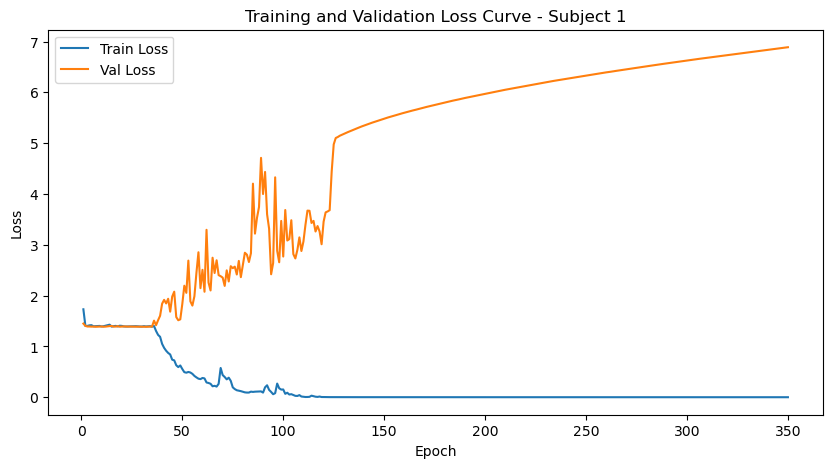

Subject 1 Accuracy: 29.86%


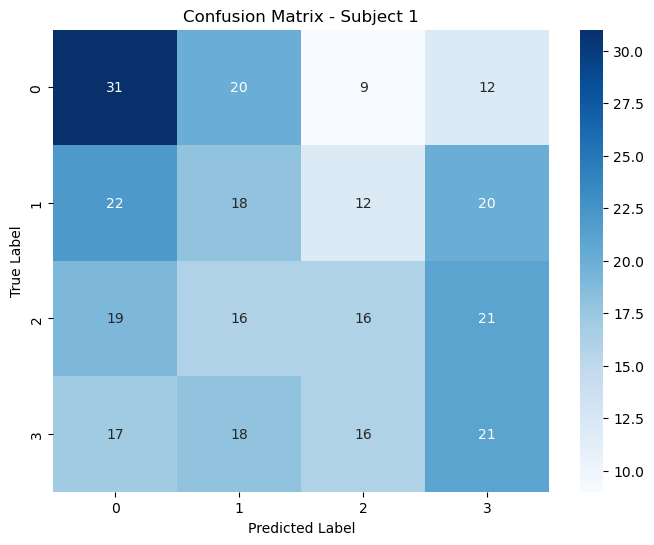


=== Training on Subject 2/9 ===
Epoch [1/350], Step [1/9], Loss: 1.4739


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/350], Train Loss: 1.6024, Val Loss: 1.5377
Epoch [50/350], Train Loss: 1.0782, Val Loss: 1.7649
Epoch [100/350], Train Loss: 0.0358, Val Loss: 3.7756
Epoch [101/350], Step [1/9], Loss: 0.2609
Epoch [150/350], Train Loss: 0.0009, Val Loss: 5.9097
Epoch [200/350], Train Loss: 0.0004, Val Loss: 6.5109
Epoch [201/350], Step [1/9], Loss: 0.0004
Epoch [250/350], Train Loss: 0.0002, Val Loss: 6.9356
Epoch [300/350], Train Loss: 0.0002, Val Loss: 7.2840
Epoch [301/350], Step [1/9], Loss: 0.0002
Epoch [350/350], Train Loss: 0.0001, Val Loss: 7.5862


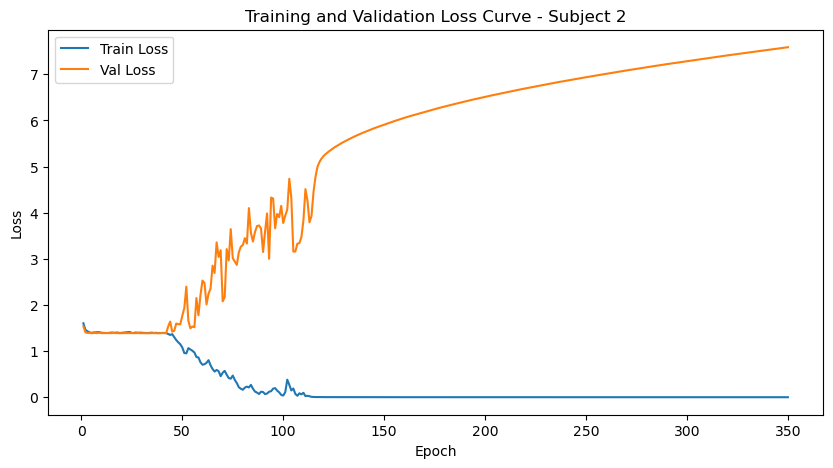

Subject 2 Accuracy: 24.31%


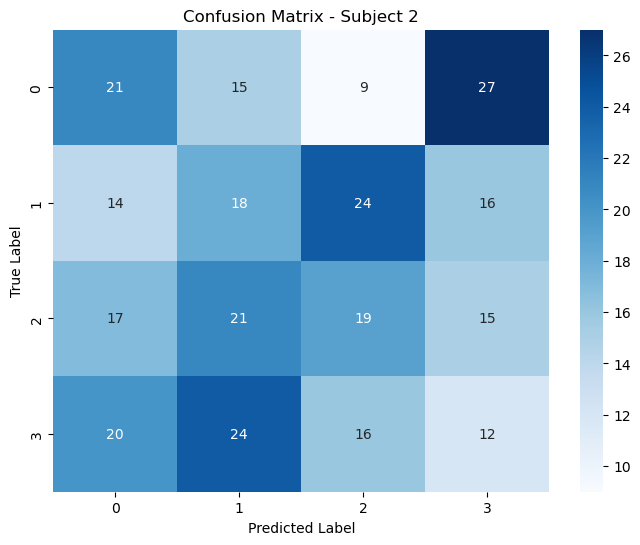


=== Training on Subject 3/9 ===
Epoch [1/350], Step [1/9], Loss: 1.3554


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/350], Train Loss: 1.7461, Val Loss: 1.5583
Epoch [50/350], Train Loss: 1.1990, Val Loss: 1.4899
Epoch [100/350], Train Loss: 0.0128, Val Loss: 3.8711
Epoch [101/350], Step [1/9], Loss: 0.0130
Epoch [150/350], Train Loss: 0.0006, Val Loss: 5.4994
Epoch [200/350], Train Loss: 0.0003, Val Loss: 5.9569
Epoch [201/350], Step [1/9], Loss: 0.0003
Epoch [250/350], Train Loss: 0.0002, Val Loss: 6.2980
Epoch [300/350], Train Loss: 0.0001, Val Loss: 6.5871
Epoch [301/350], Step [1/9], Loss: 0.0001
Epoch [350/350], Train Loss: 0.0001, Val Loss: 6.8395


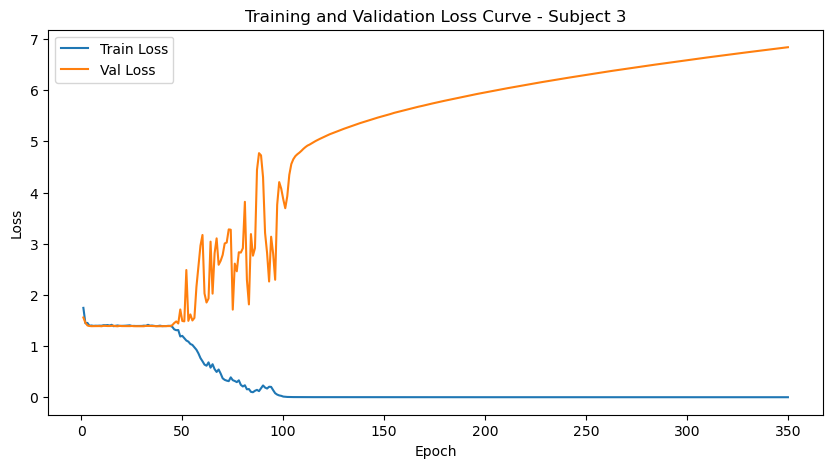

Subject 3 Accuracy: 32.29%


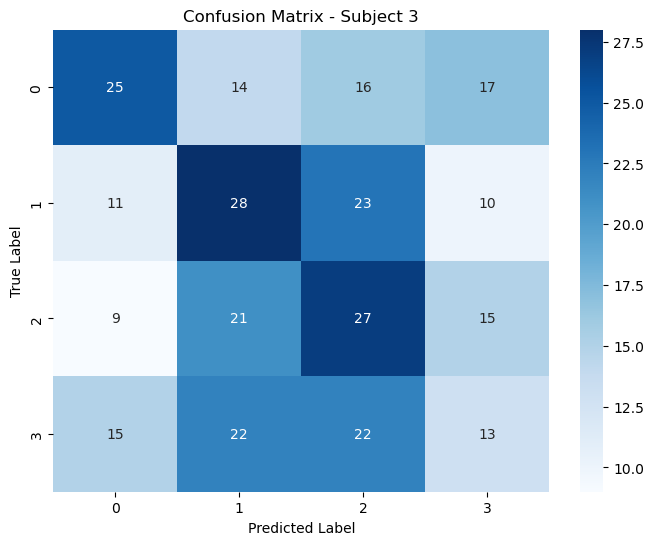


=== Training on Subject 4/9 ===
Epoch [1/350], Step [1/9], Loss: 1.6169


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/350], Train Loss: 1.6689, Val Loss: 1.4254
Epoch [50/350], Train Loss: 0.5202, Val Loss: 2.1513
Epoch [100/350], Train Loss: 0.1075, Val Loss: 3.8921
Epoch [101/350], Step [1/9], Loss: 0.0706
Epoch [150/350], Train Loss: 0.0223, Val Loss: 3.6392
Epoch [200/350], Train Loss: 0.0094, Val Loss: 4.7608
Epoch [201/350], Step [1/9], Loss: 0.0014
Epoch [250/350], Train Loss: 0.0175, Val Loss: 4.4927
Epoch [300/350], Train Loss: 0.0003, Val Loss: 5.8432
Epoch [301/350], Step [1/9], Loss: 0.0003
Epoch [350/350], Train Loss: 0.0002, Val Loss: 6.1779


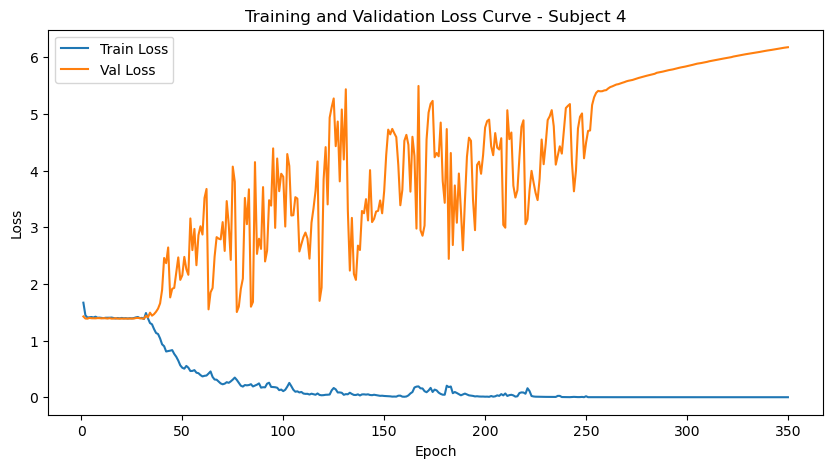

Subject 4 Accuracy: 32.64%


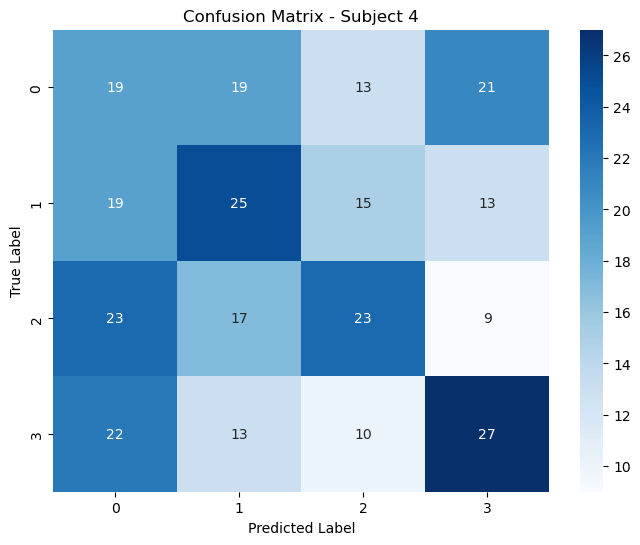


=== Training on Subject 5/9 ===
Epoch [1/350], Step [1/9], Loss: 1.4127


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/350], Train Loss: 1.6587, Val Loss: 1.5931
Epoch [50/350], Train Loss: 0.9586, Val Loss: 1.6675
Epoch [100/350], Train Loss: 0.2712, Val Loss: 2.9007
Epoch [101/350], Step [1/9], Loss: 0.3166
Epoch [150/350], Train Loss: 0.1719, Val Loss: 3.4849
Epoch [200/350], Train Loss: 0.0844, Val Loss: 3.9860
Epoch [201/350], Step [1/9], Loss: 0.0184
Epoch [250/350], Train Loss: 0.0166, Val Loss: 5.5179
Epoch [300/350], Train Loss: 0.0186, Val Loss: 4.1034
Epoch [301/350], Step [1/9], Loss: 0.0037
Epoch [350/350], Train Loss: 0.0003, Val Loss: 6.5011


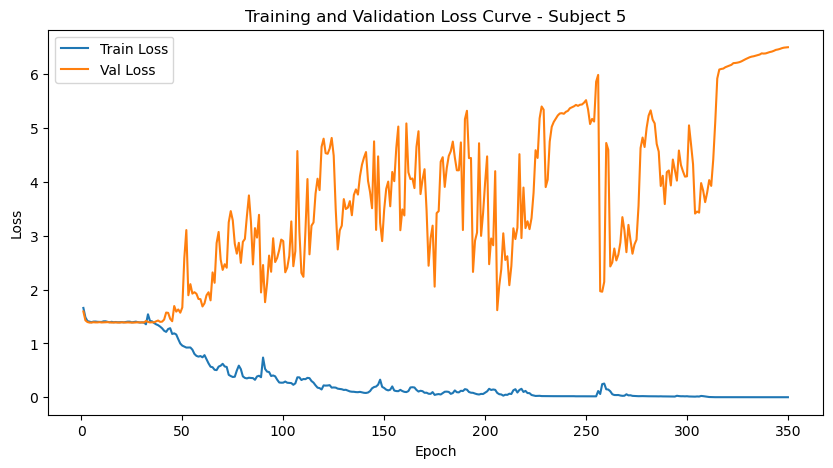

Subject 5 Accuracy: 28.47%


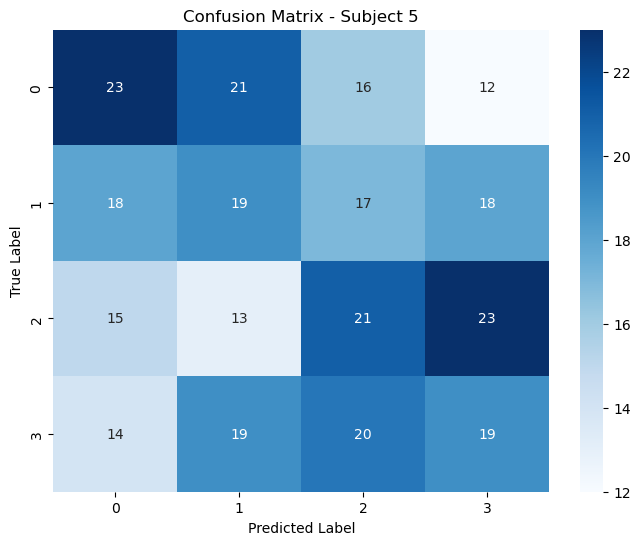


=== Training on Subject 6/9 ===
Epoch [1/350], Step [1/9], Loss: 1.6181


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/350], Train Loss: 1.7550, Val Loss: 1.5285
Epoch [50/350], Train Loss: 0.2589, Val Loss: 2.3728
Epoch [100/350], Train Loss: 0.0952, Val Loss: 1.6335
Epoch [101/350], Step [1/9], Loss: 0.0098
Epoch [150/350], Train Loss: 0.0007, Val Loss: 5.5739
Epoch [200/350], Train Loss: 0.0004, Val Loss: 6.1016
Epoch [201/350], Step [1/9], Loss: 0.0003
Epoch [250/350], Train Loss: 0.0002, Val Loss: 6.4844
Epoch [300/350], Train Loss: 0.0001, Val Loss: 6.7982
Epoch [301/350], Step [1/9], Loss: 0.0001
Epoch [350/350], Train Loss: 0.0001, Val Loss: 7.0707


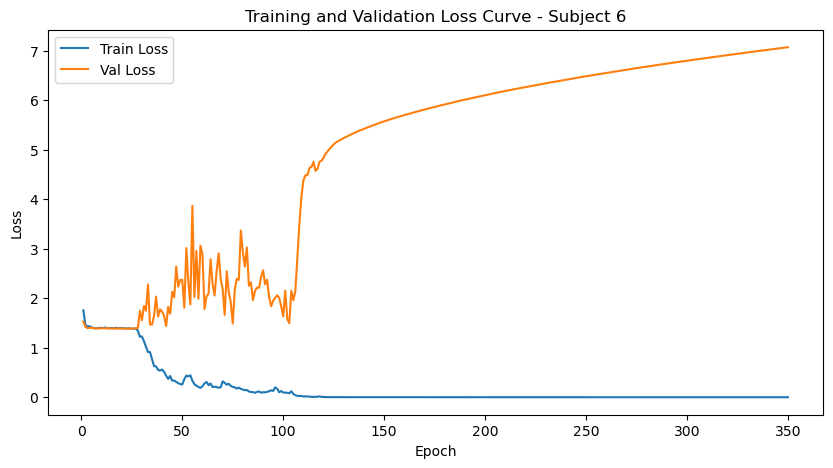

Subject 6 Accuracy: 28.82%


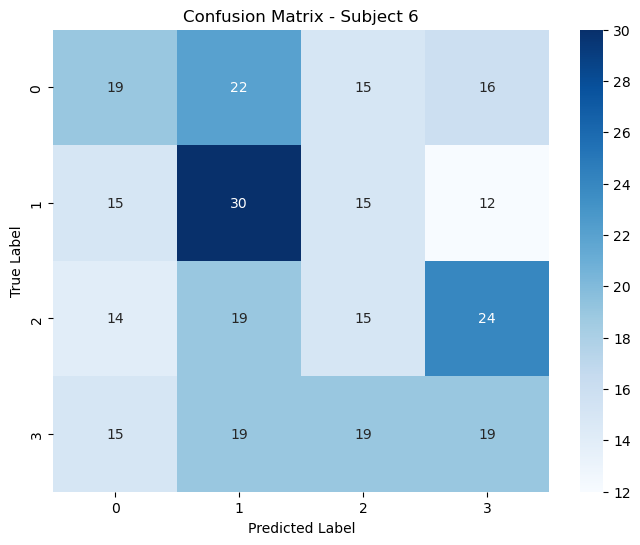


=== Training on Subject 7/9 ===
Epoch [1/350], Step [1/9], Loss: 1.4637


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/350], Train Loss: 1.7523, Val Loss: 1.4658
Epoch [50/350], Train Loss: 1.3970, Val Loss: 1.3883
Epoch [100/350], Train Loss: 0.2440, Val Loss: 1.9047
Epoch [101/350], Step [1/9], Loss: 0.1991
Epoch [150/350], Train Loss: 0.0185, Val Loss: 4.9262
Epoch [200/350], Train Loss: 0.0006, Val Loss: 5.8880
Epoch [201/350], Step [1/9], Loss: 0.0007
Epoch [250/350], Train Loss: 0.0003, Val Loss: 6.3512
Epoch [300/350], Train Loss: 0.0002, Val Loss: 6.6930
Epoch [301/350], Step [1/9], Loss: 0.0002
Epoch [350/350], Train Loss: 0.0001, Val Loss: 6.9838


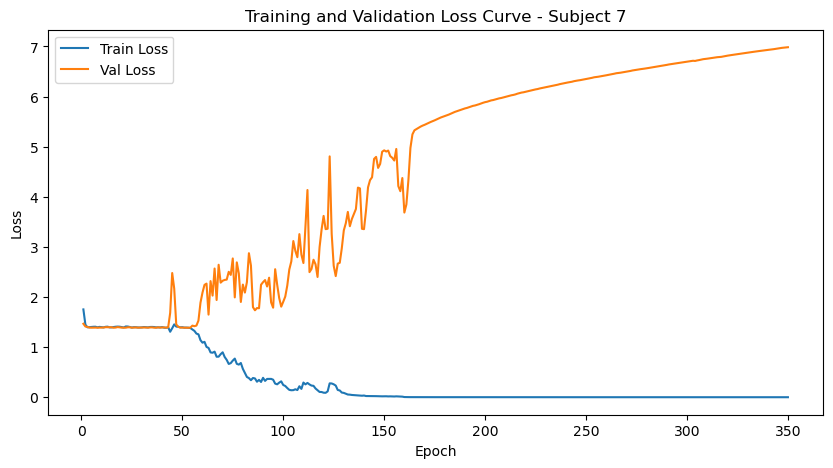

Subject 7 Accuracy: 28.12%


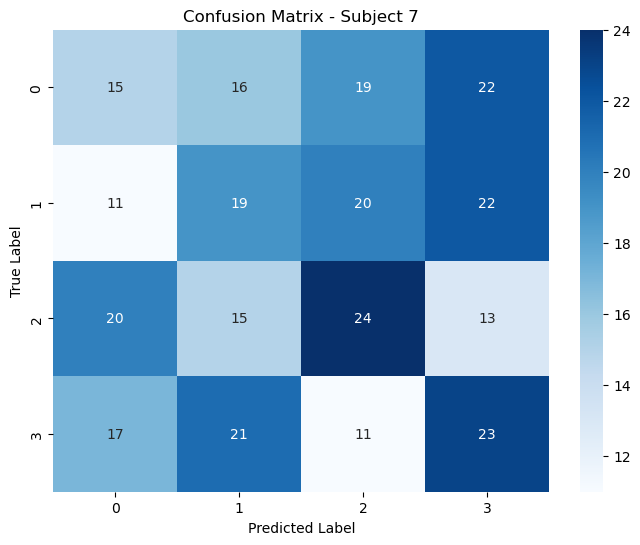


=== Training on Subject 8/9 ===
Epoch [1/350], Step [1/9], Loss: 1.4781


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/350], Train Loss: 1.7155, Val Loss: 1.6006
Epoch [50/350], Train Loss: 0.9370, Val Loss: 1.8139
Epoch [100/350], Train Loss: 0.1005, Val Loss: 2.5862
Epoch [101/350], Step [1/9], Loss: 0.0289
Epoch [150/350], Train Loss: 0.0272, Val Loss: 2.3363
Epoch [200/350], Train Loss: 0.0007, Val Loss: 5.6674
Epoch [201/350], Step [1/9], Loss: 0.0007
Epoch [250/350], Train Loss: 0.0003, Val Loss: 6.1774
Epoch [300/350], Train Loss: 0.0002, Val Loss: 6.5115
Epoch [301/350], Step [1/9], Loss: 0.0002
Epoch [350/350], Train Loss: 0.0001, Val Loss: 6.7930


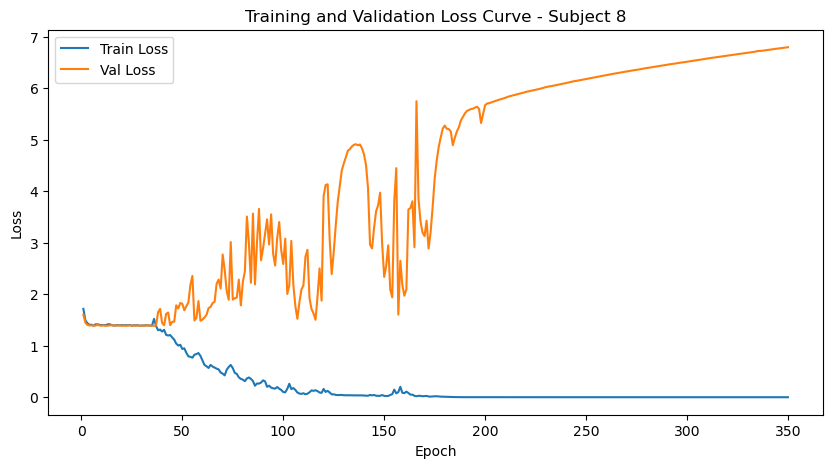

Subject 8 Accuracy: 28.12%


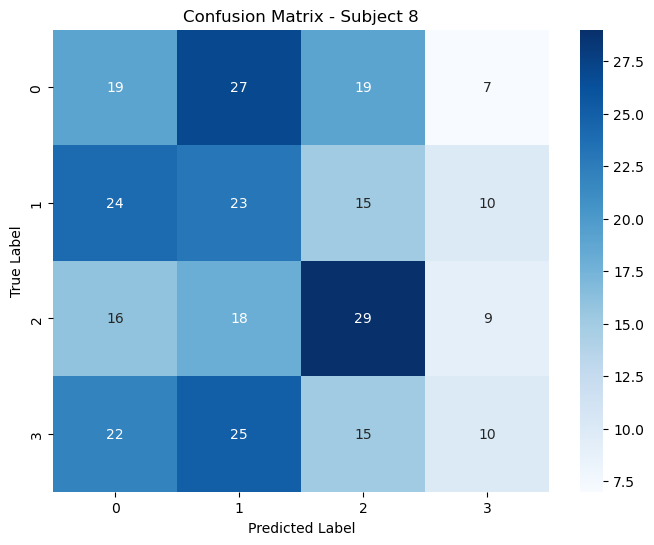


=== Training on Subject 9/9 ===
Epoch [1/350], Step [1/9], Loss: 1.5391


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/350], Train Loss: 1.6891, Val Loss: 1.5556
Epoch [50/350], Train Loss: 0.1573, Val Loss: 3.6221
Epoch [100/350], Train Loss: 0.0011, Val Loss: 5.1205
Epoch [101/350], Step [1/9], Loss: 0.0011
Epoch [150/350], Train Loss: 0.0005, Val Loss: 5.7054
Epoch [200/350], Train Loss: 0.0003, Val Loss: 6.1090
Epoch [201/350], Step [1/9], Loss: 0.0003
Epoch [250/350], Train Loss: 0.0002, Val Loss: 6.4390
Epoch [300/350], Train Loss: 0.0001, Val Loss: 6.7287
Epoch [301/350], Step [1/9], Loss: 0.0001
Epoch [350/350], Train Loss: 0.0001, Val Loss: 6.9887


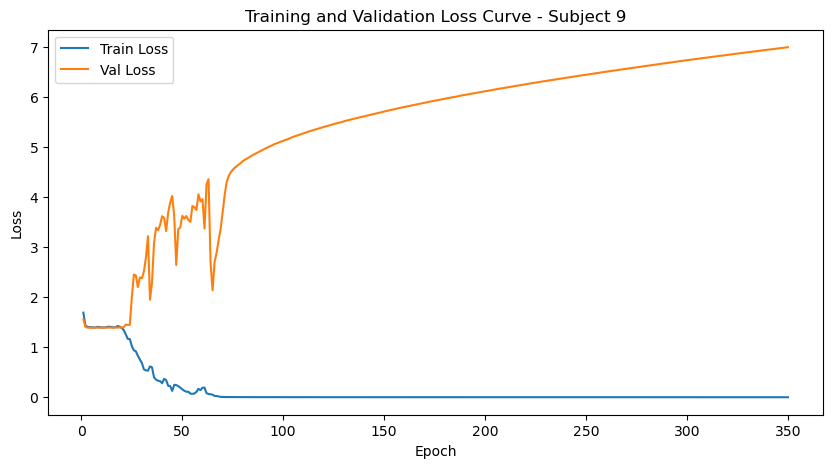

Subject 9 Accuracy: 29.86%


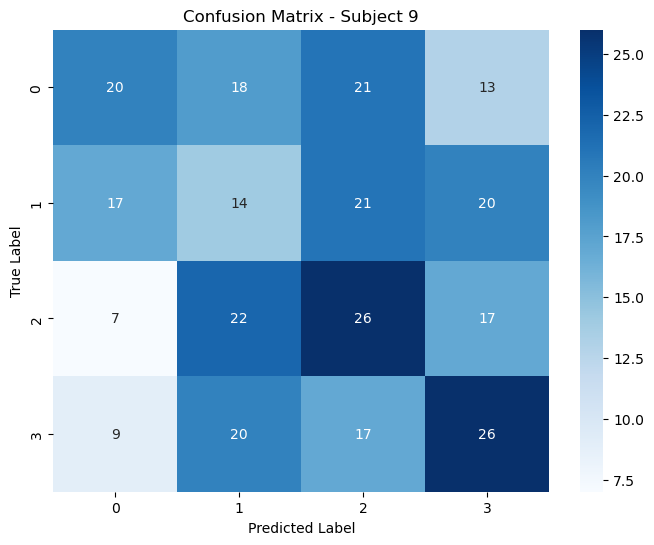


Mean Accuracy across all subjects: 29.17%


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

# Set random seed for reproducibility
torch.manual_seed(2003)

# Define data paths
data_path = ['A0' + str(i) + j for i in range(1, 10) for j in ['T', 'E']]
# Example: ['A01T', 'A01E', 'A02T', 'A02E', ..., 'A09T', 'A09E']

# Initialize accuracy storage
num_subjects = len(data_path) // 2
accuracy_train = np.zeros((num_subjects, 1))
accuracy_test = np.zeros((num_subjects, 1))  # Currently not used

# Training parameters
epochs = 350
batch_size = 32
learning_rate = 1e-3
n_classes = 4
channels = 22
samples = 1125

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Loop over each subject's dataset
for sub in range(num_subjects):
    print(f"\n=== Training on Subject {sub + 1}/{num_subjects} ===")
    
    # Load training data
    train_data = np.load(f'2a_pre/{data_path[2 * sub]}.npz')
    train_inputs = torch.Tensor(train_data['data'])  # Assuming shape [num_samples, channels, samples]
    train_labels = torch.Tensor(train_data['label']).long() - 1  # Labels adjusted to start from 0
    
    # Load validation data
    val_data = np.load(f'2a_pre/{data_path[2 * sub + 1]}.npz')
    val_inputs = torch.Tensor(val_data['data'])
    val_labels = torch.Tensor(val_data['label']).long() - 1
    
    # Initialize the Transformer-based model
    model = TransformerEEGNet(
        n_classes=n_classes,
        channels=channels,
        samples=samples,
        d_model=128,           # You can adjust these hyperparameters
        nhead=8,
        num_layers=4,
        dim_feedforward=512,
        dropout=0.1
    ).to(device)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Reshape inputs if necessary
    # Ensure that the data shape matches [batch_size, 1, channels, samples]
    train_inputs = train_inputs.reshape(-1, 1, channels, samples).to(device)
    val_inputs = val_inputs.reshape(-1, 1, channels, samples).to(device)
    train_labels = train_labels.to(device)
    val_labels = val_labels.to(device)
    
    # Create TensorDatasets and DataLoaders
    train_dataset = TensorDataset(train_inputs, train_labels)
    val_dataset = TensorDataset(val_inputs, val_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Shuffle=False for evaluation
    
    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for i, (inputs, targets) in enumerate(train_loader):
            # Inputs and targets are already on the correct device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            
            # Print progress every 100 epochs and every 10 batches
            if (epoch % 100 == 0) and (i % 10 == 0):
                print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # Calculate average training loss for the epoch
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
        
        # Calculate average validation loss for the epoch
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Optionally, print epoch summary
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    # Evaluation after training
    model.eval()
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curve - Subject {sub + 1}')
    plt.legend()
    plt.show()
    
    # Calculate confusion matrix and accuracy
    cm = confusion_matrix(all_targets, all_predictions)
    accuracy = np.trace(cm) / np.sum(cm)
    accuracy_train[sub] = accuracy
    print(f'Subject {sub + 1} Accuracy: {accuracy * 100:.2f}%')
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(n_classes), yticklabels=range(n_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - Subject {sub + 1}')
    plt.show()
    
    # Optionally, save the model for each subject
    # torch.save(model.state_dict(), f"TransformerEEGNet_subject_{sub + 1}.pth")

# Calculate and print mean accuracy across all subjects
mean_accuracy_train = np.mean(accuracy_train) * 100
print(f'\nMean Accuracy across all subjects: {mean_accuracy_train:.2f}%')


Using device: cuda

=== Training on Subject 1/9 ===


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Step [1/9], Loss: 1.5034
Epoch [1/350], Train Loss: 1.7064, Val Loss: 1.4149
Early stopping triggered after 33 epochs.


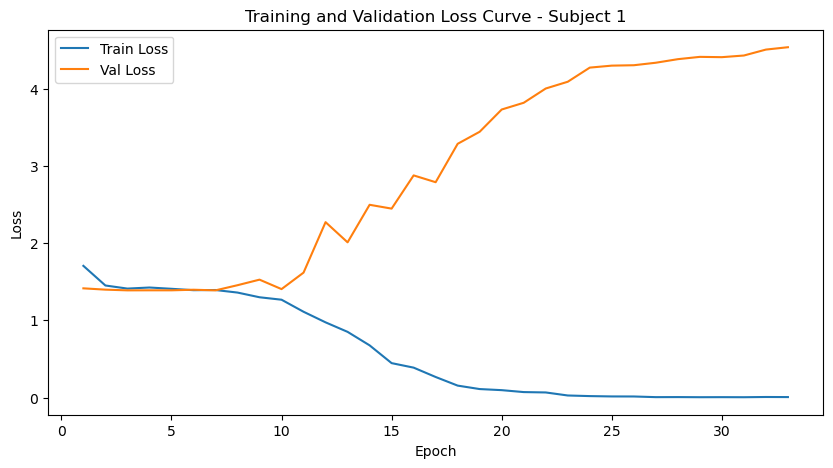

Subject 1 Accuracy: 25.00%
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        72
           1     0.0000    0.0000    0.0000        72
           2     0.2500    1.0000    0.4000        72
           3     0.0000    0.0000    0.0000        72

    accuracy                         0.2500       288
   macro avg     0.0625    0.2500    0.1000       288
weighted avg     0.0625    0.2500    0.1000       288



C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


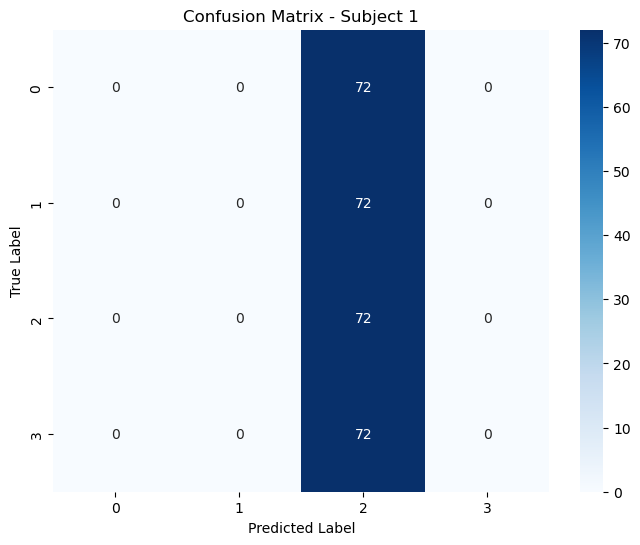


=== Training on Subject 2/9 ===
Epoch [1/350], Step [1/9], Loss: 1.3533


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Train Loss: 1.7495, Val Loss: 1.3912
Early stopping triggered after 35 epochs.


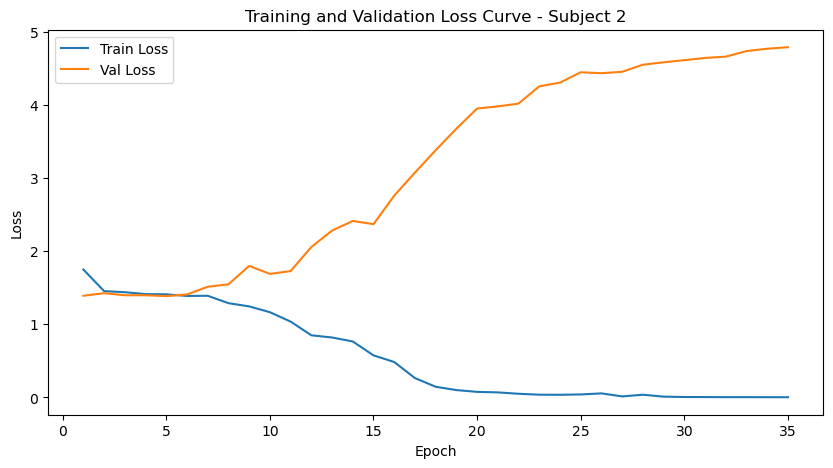

Subject 2 Accuracy: 26.74%
Classification Report:
              precision    recall  f1-score   support

           0     0.2887    0.3889    0.3314        72
           1     0.0000    0.0000    0.0000        72
           2     0.2174    0.0694    0.1053        72
           3     0.2619    0.6111    0.3667        72

    accuracy                         0.2674       288
   macro avg     0.1920    0.2674    0.2008       288
weighted avg     0.1920    0.2674    0.2008       288



C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


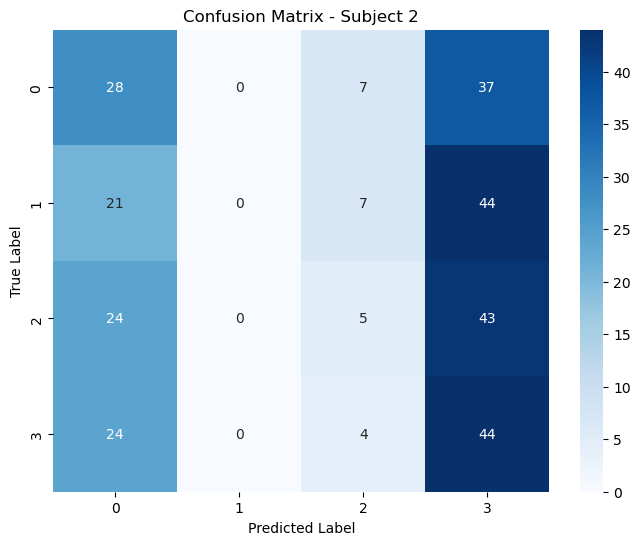


=== Training on Subject 3/9 ===
Epoch [1/350], Step [1/9], Loss: 1.4438


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Train Loss: 1.6552, Val Loss: 1.3895
Early stopping triggered after 34 epochs.


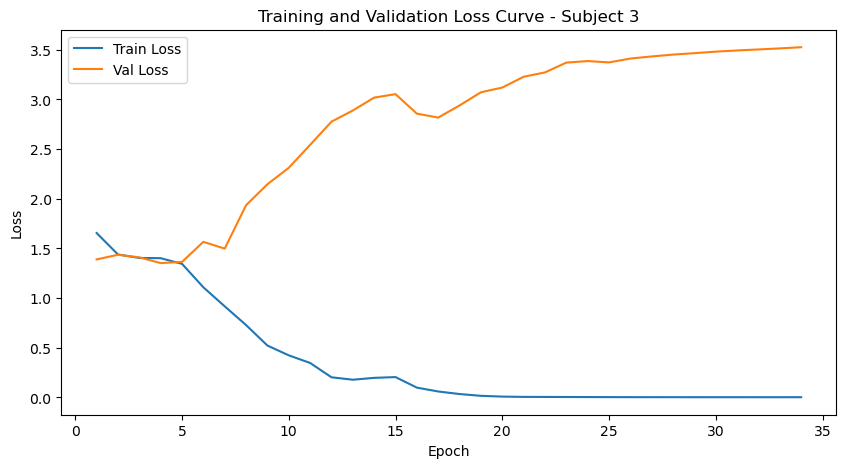

Subject 3 Accuracy: 31.60%
Classification Report:
              precision    recall  f1-score   support

           0     0.3110    0.9028    0.4626        72
           1     0.0000    0.0000    0.0000        72
           2     0.3291    0.3611    0.3444        72
           3     0.0000    0.0000    0.0000        72

    accuracy                         0.3160       288
   macro avg     0.1600    0.3160    0.2018       288
weighted avg     0.1600    0.3160    0.2018       288



C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


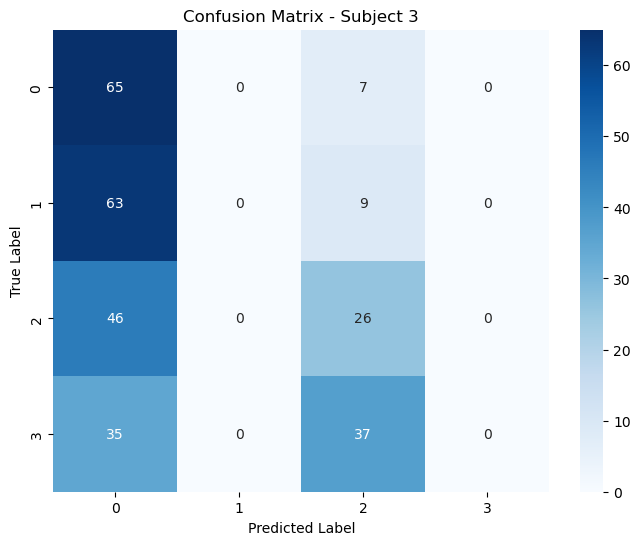


=== Training on Subject 4/9 ===
Epoch [1/350], Step [1/9], Loss: 1.3806


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Train Loss: 1.8601, Val Loss: 1.3951
Early stopping triggered after 37 epochs.


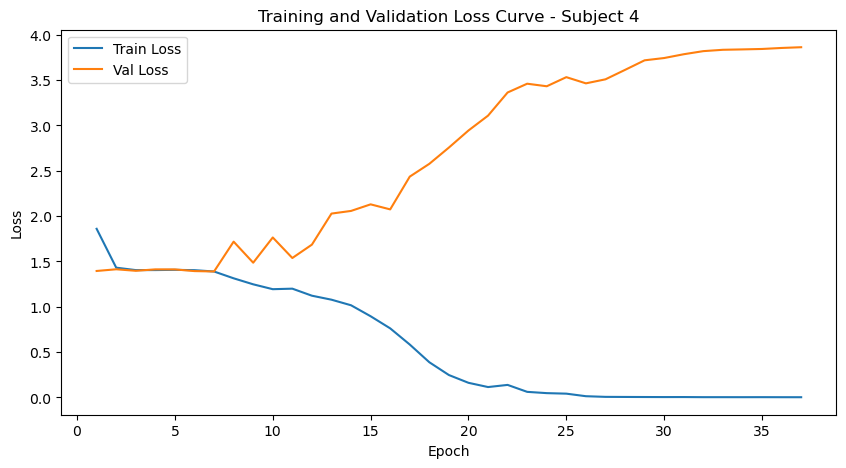

Subject 4 Accuracy: 27.43%
Classification Report:
              precision    recall  f1-score   support

           0     0.2344    0.6250    0.3409        72
           1     0.5000    0.1250    0.2000        72
           2     0.0000    0.0000    0.0000        72
           3     0.3205    0.3472    0.3333        72

    accuracy                         0.2743       288
   macro avg     0.2637    0.2743    0.2186       288
weighted avg     0.2637    0.2743    0.2186       288



C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


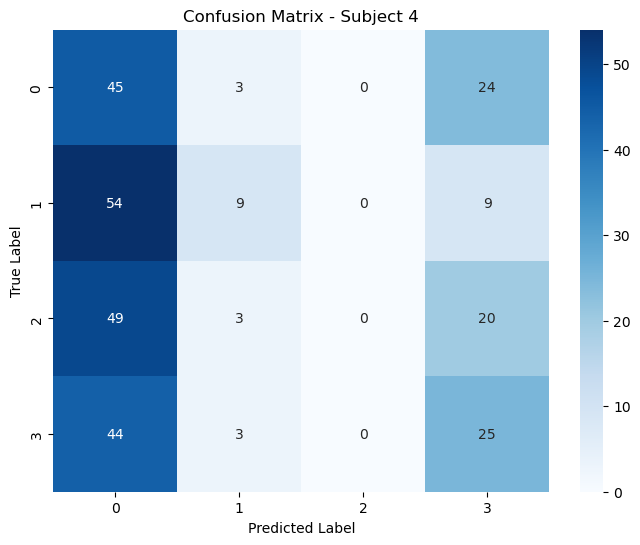


=== Training on Subject 5/9 ===
Epoch [1/350], Step [1/9], Loss: 1.4630


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Train Loss: 1.7448, Val Loss: 1.5722
Early stopping triggered after 42 epochs.


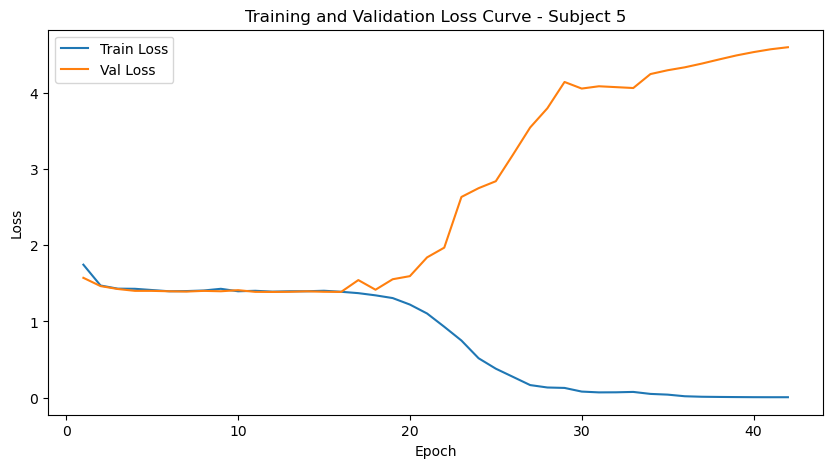

Subject 5 Accuracy: 25.00%
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        72
           1     0.0000    0.0000    0.0000        72
           2     0.0000    0.0000    0.0000        72
           3     0.2500    1.0000    0.4000        72

    accuracy                         0.2500       288
   macro avg     0.0625    0.2500    0.1000       288
weighted avg     0.0625    0.2500    0.1000       288



C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


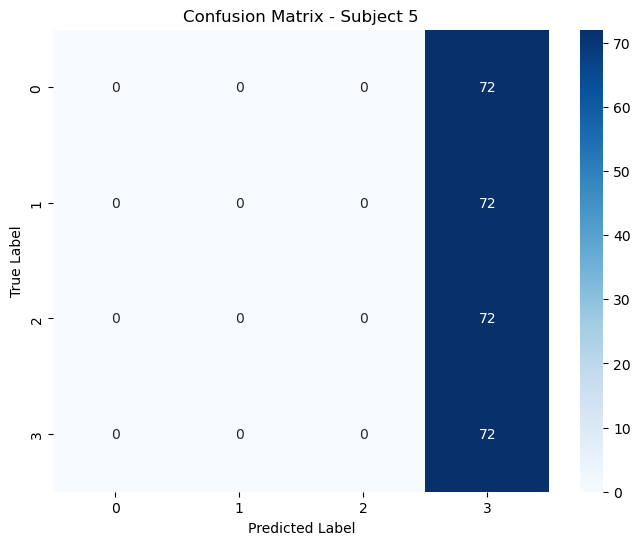


=== Training on Subject 6/9 ===
Epoch [1/350], Step [1/9], Loss: 1.5343


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Train Loss: 1.6746, Val Loss: 1.4231
Early stopping triggered after 43 epochs.


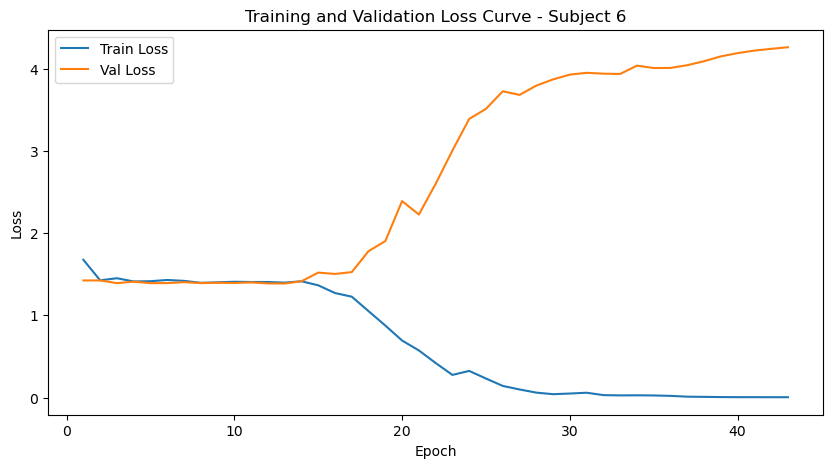

Subject 6 Accuracy: 27.08%
Classification Report:
              precision    recall  f1-score   support

           0     0.2549    0.5417    0.3467        72
           1     0.0000    0.0000    0.0000        72
           2     0.2889    0.5417    0.3768        72
           3     0.0000    0.0000    0.0000        72

    accuracy                         0.2708       288
   macro avg     0.1359    0.2708    0.1809       288
weighted avg     0.1359    0.2708    0.1809       288



C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


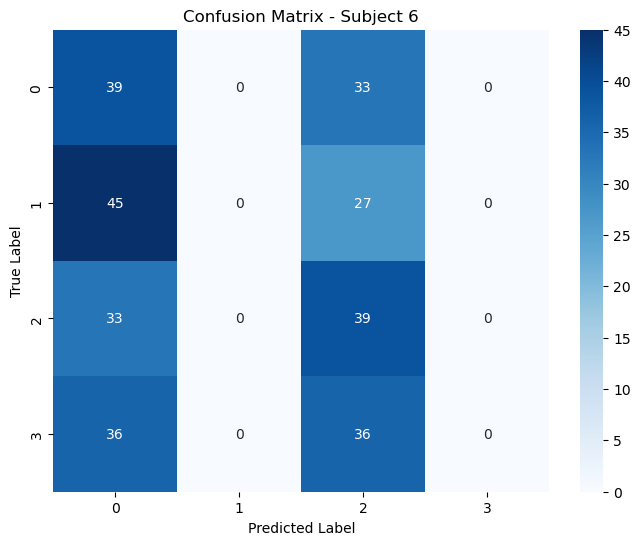


=== Training on Subject 7/9 ===
Epoch [1/350], Step [1/9], Loss: 1.4323


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Train Loss: 1.5906, Val Loss: 1.4570
Early stopping triggered after 36 epochs.


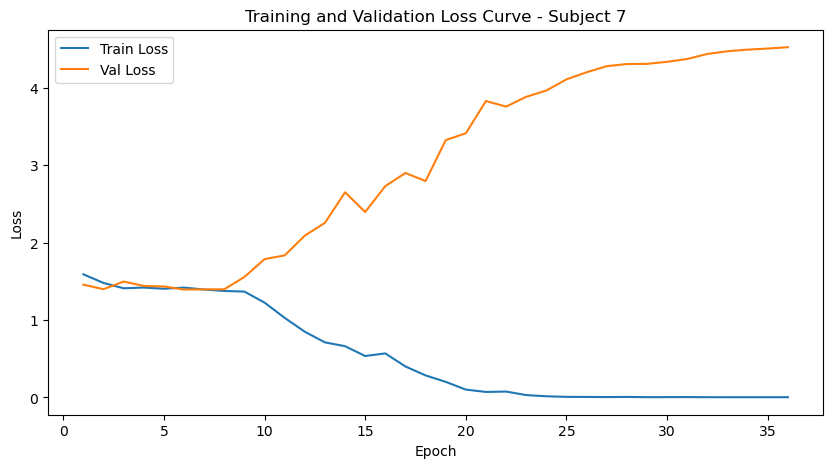

Subject 7 Accuracy: 25.00%
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        72
           1     0.2500    1.0000    0.4000        72
           2     0.0000    0.0000    0.0000        72
           3     0.0000    0.0000    0.0000        72

    accuracy                         0.2500       288
   macro avg     0.0625    0.2500    0.1000       288
weighted avg     0.0625    0.2500    0.1000       288



C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


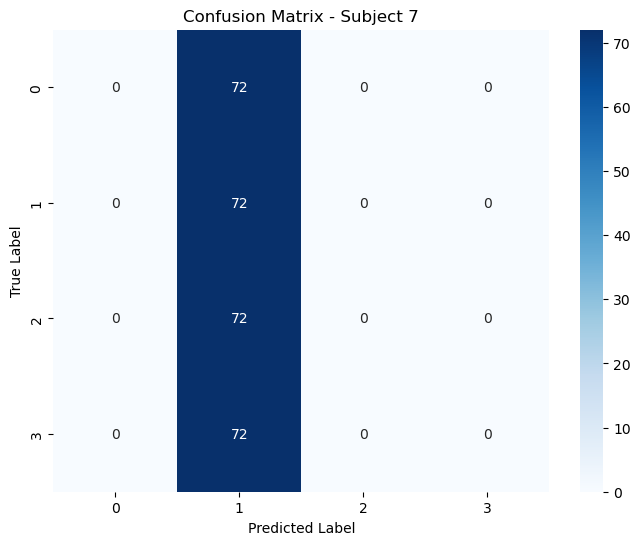


=== Training on Subject 8/9 ===
Epoch [1/350], Step [1/9], Loss: 1.4905


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Train Loss: 1.7201, Val Loss: 1.4054
Early stopping triggered after 34 epochs.


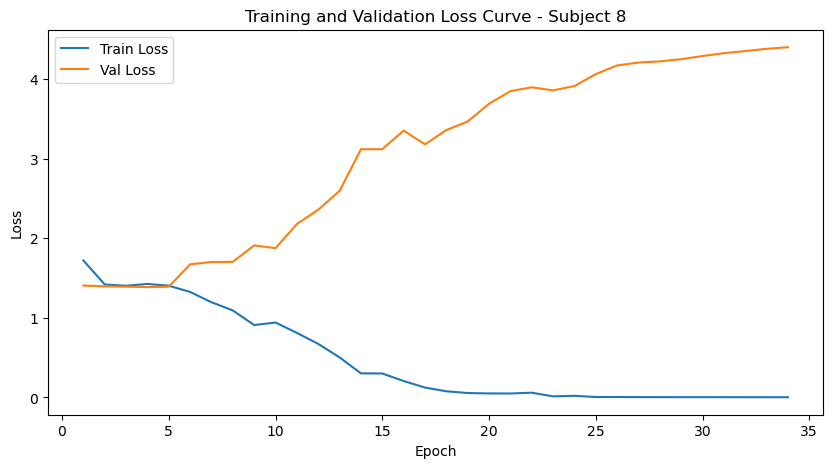

Subject 8 Accuracy: 25.69%
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        72
           1     0.4000    0.0278    0.0519        72
           2     0.0000    0.0000    0.0000        72
           3     0.2544    1.0000    0.4056        72

    accuracy                         0.2569       288
   macro avg     0.1636    0.2569    0.1144       288
weighted avg     0.1636    0.2569    0.1144       288



C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vis_l\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


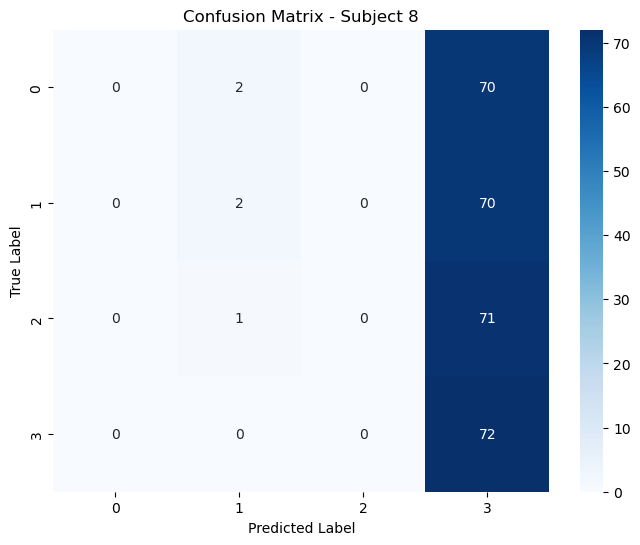


=== Training on Subject 9/9 ===
Epoch [1/350], Step [1/9], Loss: 1.4340


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Train Loss: 1.7170, Val Loss: 1.4201
Early stopping triggered after 35 epochs.


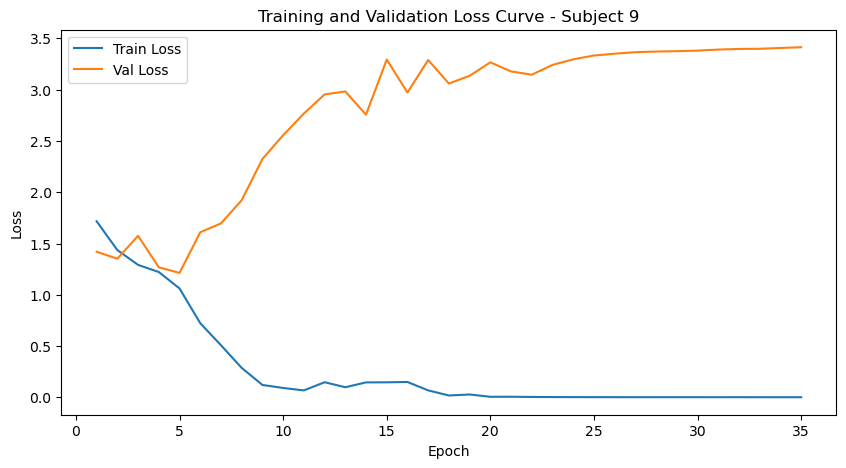

Subject 9 Accuracy: 46.18%
Classification Report:
              precision    recall  f1-score   support

           0     0.4865    0.7500    0.5902        72
           1     0.3265    0.2222    0.2645        72
           2     0.3750    0.0833    0.1364        72
           3     0.5089    0.7917    0.6196        72

    accuracy                         0.4618       288
   macro avg     0.4242    0.4618    0.4026       288
weighted avg     0.4242    0.4618    0.4026       288



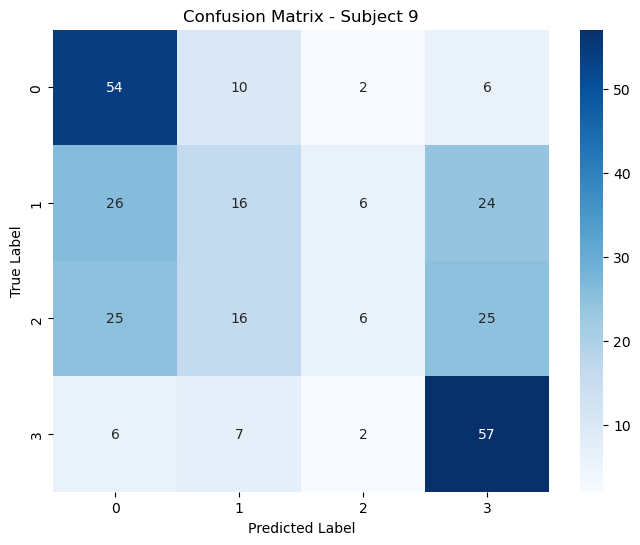


Mean Accuracy across all subjects: 28.86%


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

# Ensure TransformerEEGNet is defined in the same script or imported correctly
# from TransformerEEGNet import TransformerEEGNet

# Set random seed for reproducibility
torch.manual_seed(2003)
np.random.seed(2003)

# Define data paths
data_path = ['A0' + str(i) + j for i in range(1, 10) for j in ['T', 'E']]
# Example: ['A01T', 'A01E', 'A02T', 'A02E', ..., 'A09T', 'A09E']

# Initialize accuracy storage
num_subjects = len(data_path) // 2
accuracy_train = np.zeros((num_subjects, 1))
accuracy_test = np.zeros((num_subjects, 1))  # Currently not used

# Training parameters
epochs = 350
batch_size = 32
learning_rate = 1e-3
n_classes = 4
channels = 22
samples = 1125

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Early Stopping Parameters
patience = 30  # Number of epochs to wait before stopping if no improvement
best_val_loss = np.inf
epochs_no_improve = 0

# Loop over each subject's dataset
for sub in range(num_subjects):
    print(f"\n=== Training on Subject {sub + 1}/{num_subjects} ===")
    
    # Load training data
    train_data = np.load(f'2a_pre/{data_path[2 * sub]}.npz')
    train_inputs = torch.Tensor(train_data['data'])  # Assuming shape [num_samples, channels, samples]
    train_labels = torch.Tensor(train_data['label']).long() - 1  # Labels adjusted to start from 0
    
    # Load validation data
    val_data = np.load(f'2a_pre/{data_path[2 * sub + 1]}.npz')
    val_inputs = torch.Tensor(val_data['data'])
    val_labels = torch.Tensor(val_data['label']).long() - 1
    
    # Normalize the data (zero mean and unit variance)
    mean = train_inputs.mean(dim=(0, 2), keepdim=True)
    std = train_inputs.std(dim=(0, 2), keepdim=True) + 1e-6  # Add epsilon to avoid division by zero
    train_inputs = (train_inputs - mean) / std
    val_inputs = (val_inputs - mean) / std  # Use training mean and std for validation
    
    # Initialize the Transformer-based model
    model = TransformerEEGNet(
        n_classes=n_classes,
        channels=channels,
        samples=samples,
        d_model=128,           # You can adjust these hyperparameters
        nhead=8,
        num_layers=4,
        dim_feedforward=512,
        dropout=0.3  # Increased dropout for better regularization
    ).to(device)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Added weight decay
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                     factor=0.5, patience=10, 
                                                     verbose=True, min_lr=1e-6)
    
    # Reshape inputs to [batch_size, 1, channels, samples]
    train_inputs = train_inputs.reshape(-1, 1, channels, samples).to(device)
    val_inputs = val_inputs.reshape(-1, 1, channels, samples).to(device)
    train_labels = train_labels.to(device)
    val_labels = val_labels.to(device)
    
    # Create TensorDatasets and DataLoaders
    train_dataset = TensorDataset(train_inputs, train_labels)
    val_dataset = TensorDataset(val_inputs, val_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Shuffle=False for evaluation
    
    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    
    # Reset early stopping parameters
    best_val_loss = np.inf
    epochs_no_improve = 0
    best_model_state = None
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for i, (inputs, targets) in enumerate(train_loader):
            # Inputs and targets are already on the correct device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            running_train_loss += loss.item()
            
            # Print progress every 100 epochs and every 10 batches
            if (epoch % 100 == 0) and (i % 10 == 0):
                print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # Calculate average training loss for the epoch
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
        
        # Calculate average validation loss for the epoch
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Step the scheduler
        scheduler.step(avg_val_loss)
        
        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs.')
                break
        
        # Optionally, print epoch summary
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Evaluation after training
    model.eval()
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curve - Subject {sub + 1}')
    plt.legend()
    plt.show()
    
    # Calculate confusion matrix and accuracy
    cm = confusion_matrix(all_targets, all_predictions)
    accuracy = np.trace(cm) / np.sum(cm)
    accuracy_train[sub] = accuracy
    print(f'Subject {sub + 1} Accuracy: {accuracy * 100:.2f}%')
    
    # Detailed classification report
    print("Classification Report:")
    print(classification_report(all_targets, all_predictions, digits=4))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(n_classes), yticklabels=range(n_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - Subject {sub + 1}')
    plt.show()
    
    # Optionally, save the model for each subject
    # torch.save(model.state_dict(), f"TransformerEEGNet_subject_{sub + 1}.pth")

# Calculate and print mean accuracy across all subjects
mean_accuracy_train = np.mean(accuracy_train) * 100
print(f'\nMean Accuracy across all subjects: {mean_accuracy_train:.2f}%')


Using device: cuda

=== Training on Subject 1/9 ===


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Step [1/9], Loss: 1.5034
Epoch [1/350], Train Loss: 1.7062, Val Loss: 1.4155
Early stopping triggered after 37 epochs.


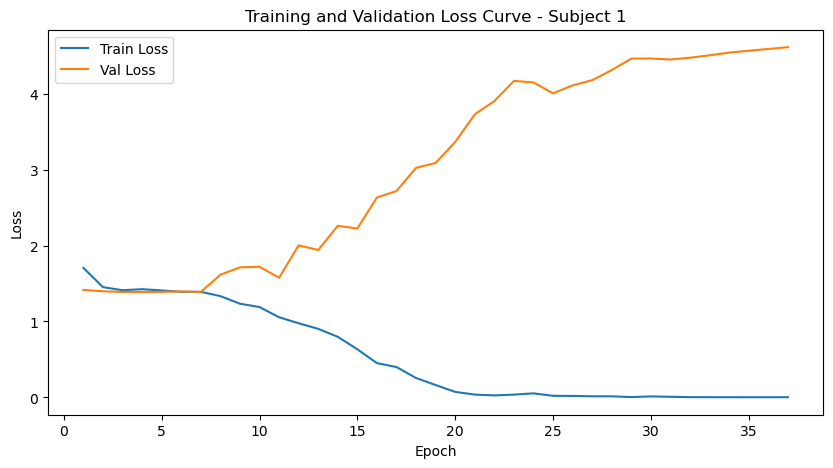

Subject 1 Accuracy: 23.26%
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        72
           1     0.1000    0.0139    0.0244        72
           2     0.0000    0.0000    0.0000        72
           3     0.2374    0.9167    0.3771        72

    accuracy                         0.2326       288
   macro avg     0.0844    0.2326    0.1004       288
weighted avg     0.0844    0.2326    0.1004       288



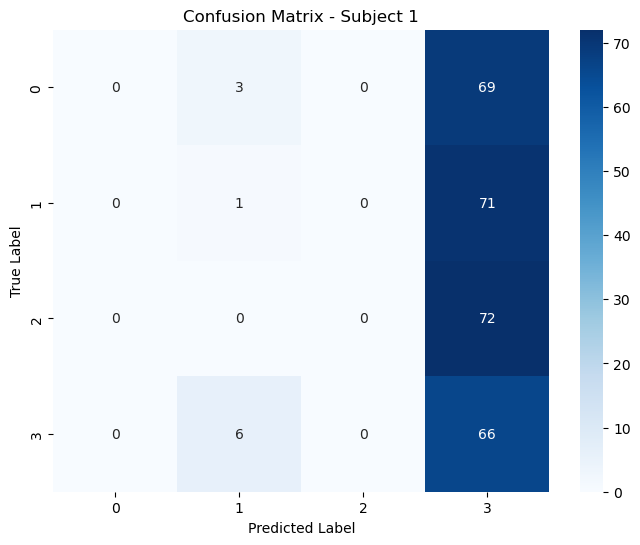


=== Training on Subject 2/9 ===
Epoch [1/350], Step [1/9], Loss: 1.5530


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Train Loss: 1.6005, Val Loss: 1.4322
Early stopping triggered after 33 epochs.


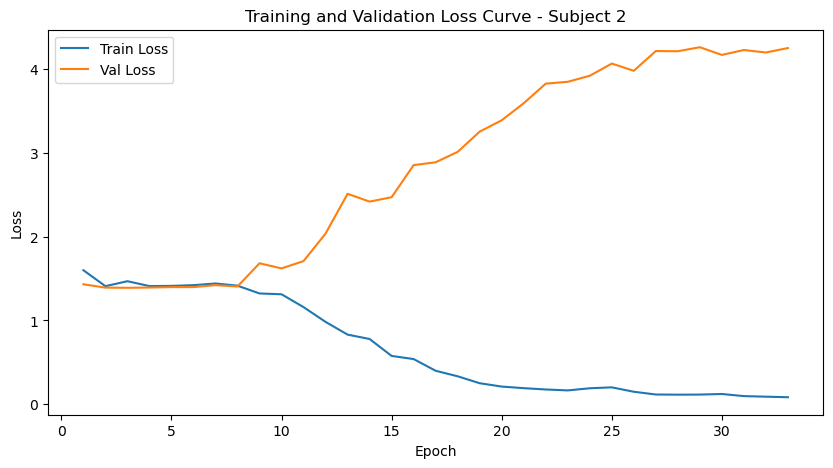

Subject 2 Accuracy: 25.00%
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        72
           1     0.0000    0.0000    0.0000        72
           2     0.0000    0.0000    0.0000        72
           3     0.2500    1.0000    0.4000        72

    accuracy                         0.2500       288
   macro avg     0.0625    0.2500    0.1000       288
weighted avg     0.0625    0.2500    0.1000       288



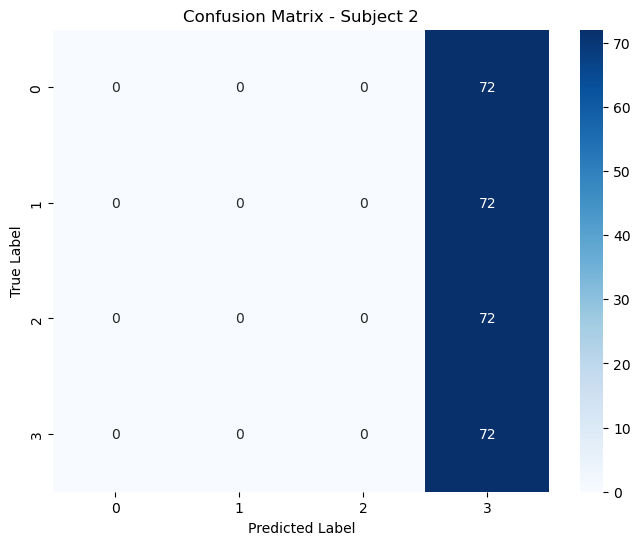


=== Training on Subject 3/9 ===
Epoch [1/350], Step [1/9], Loss: 1.4580


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Train Loss: 1.6150, Val Loss: 1.3940
Early stopping triggered after 35 epochs.


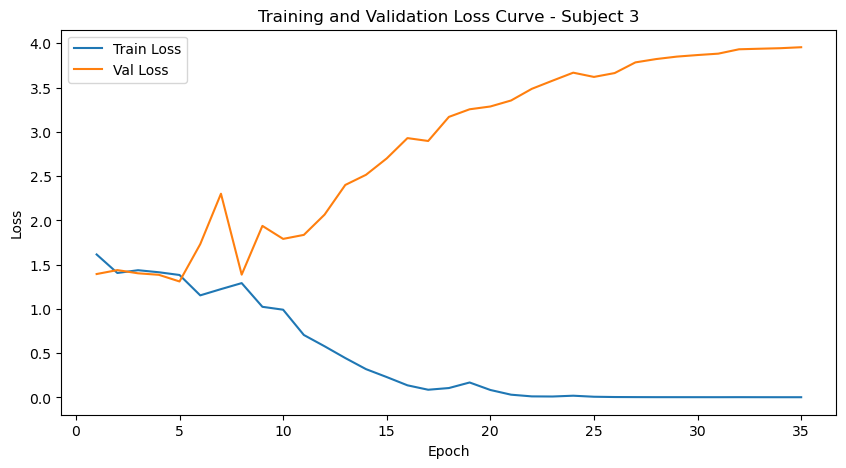

Subject 3 Accuracy: 29.86%
Classification Report:
              precision    recall  f1-score   support

           0     0.4783    0.1528    0.2316        72
           1     0.0000    0.0000    0.0000        72
           2     0.1594    0.3056    0.2095        72
           3     0.4173    0.7361    0.5327        72

    accuracy                         0.2986       288
   macro avg     0.2638    0.2986    0.2434       288
weighted avg     0.2638    0.2986    0.2434       288



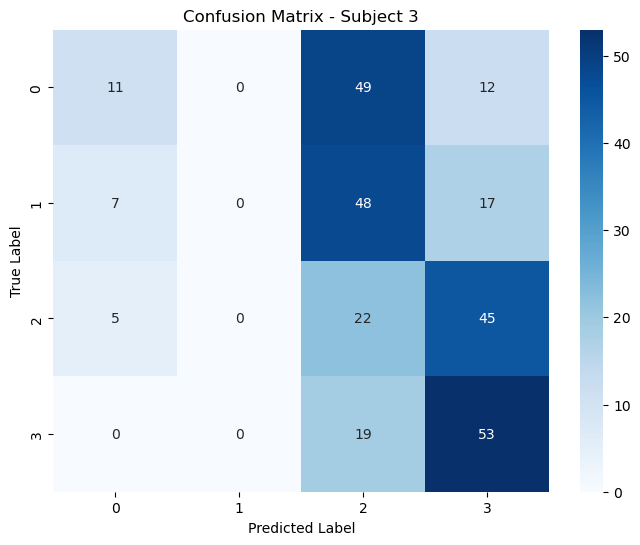


=== Training on Subject 4/9 ===
Epoch [1/350], Step [1/9], Loss: 1.3695


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Train Loss: 1.6980, Val Loss: 1.4013
Early stopping triggered after 35 epochs.


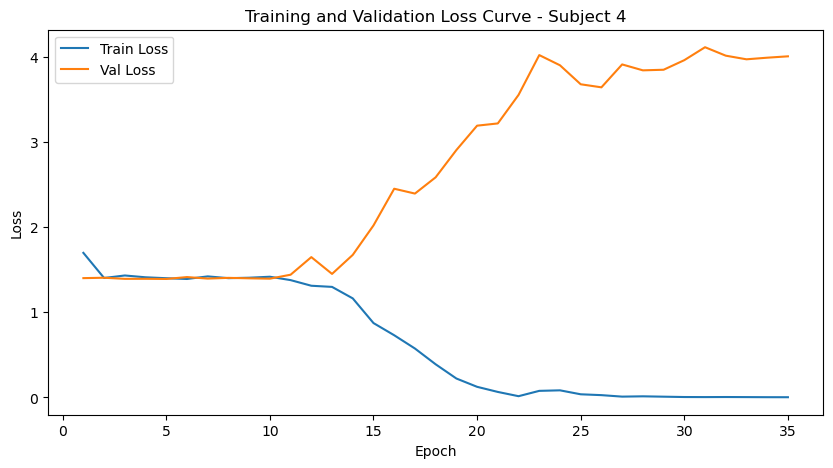

Subject 4 Accuracy: 25.00%
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        72
           1     0.0000    0.0000    0.0000        72
           2     0.0000    0.0000    0.0000        72
           3     0.2500    1.0000    0.4000        72

    accuracy                         0.2500       288
   macro avg     0.0625    0.2500    0.1000       288
weighted avg     0.0625    0.2500    0.1000       288



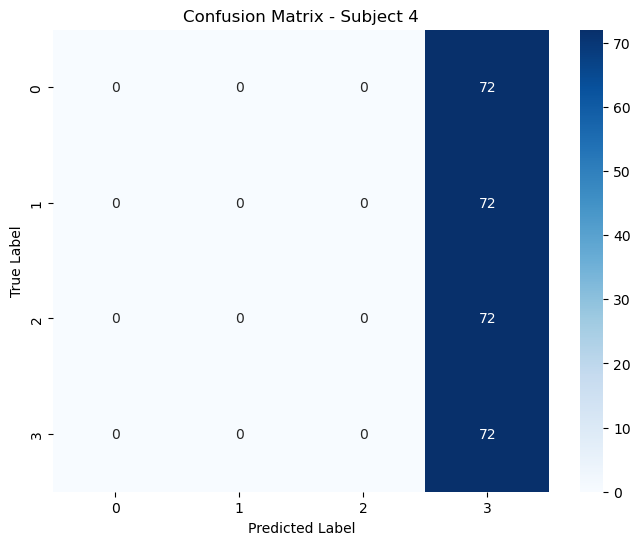


=== Training on Subject 5/9 ===
Epoch [1/350], Step [1/9], Loss: 1.3932


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Train Loss: 1.7304, Val Loss: 1.3933
Early stopping triggered after 33 epochs.


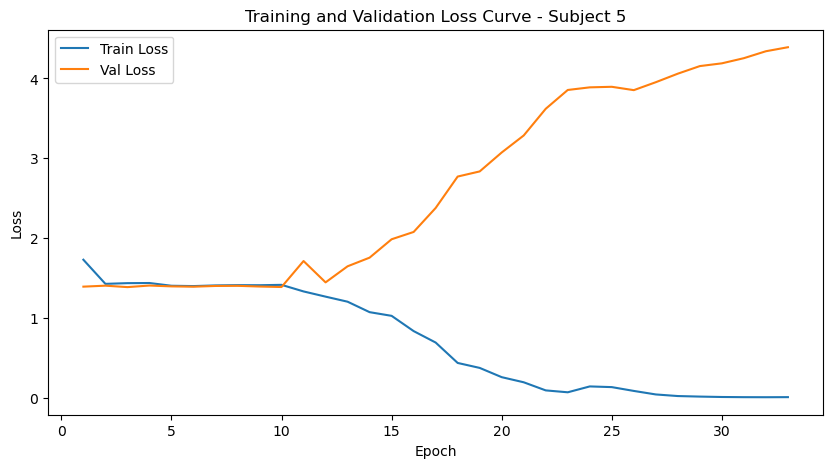

Subject 5 Accuracy: 25.00%
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        72
           1     0.0000    0.0000    0.0000        72
           2     0.0000    0.0000    0.0000        72
           3     0.2500    1.0000    0.4000        72

    accuracy                         0.2500       288
   macro avg     0.0625    0.2500    0.1000       288
weighted avg     0.0625    0.2500    0.1000       288



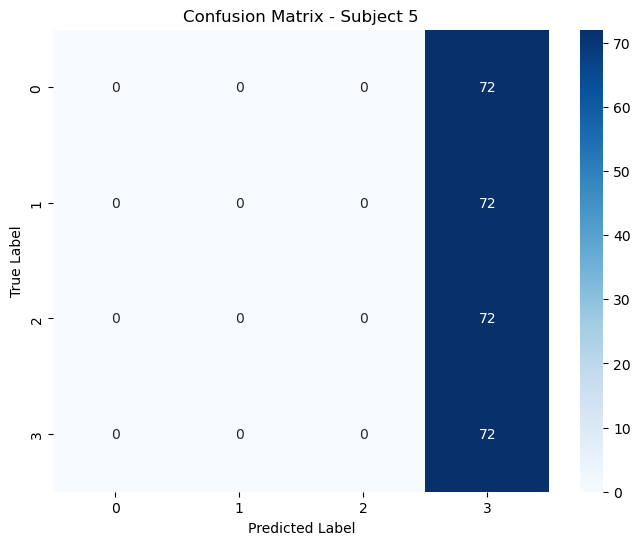


=== Training on Subject 6/9 ===
Epoch [1/350], Step [1/9], Loss: 1.3670


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Train Loss: 1.7182, Val Loss: 1.4270
Early stopping triggered after 33 epochs.


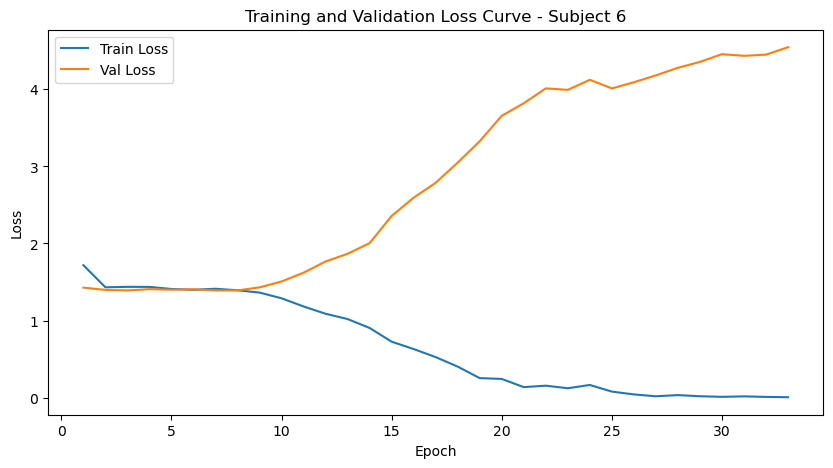

Subject 6 Accuracy: 25.00%
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        72
           1     0.0000    0.0000    0.0000        72
           2     0.0000    0.0000    0.0000        72
           3     0.2500    1.0000    0.4000        72

    accuracy                         0.2500       288
   macro avg     0.0625    0.2500    0.1000       288
weighted avg     0.0625    0.2500    0.1000       288



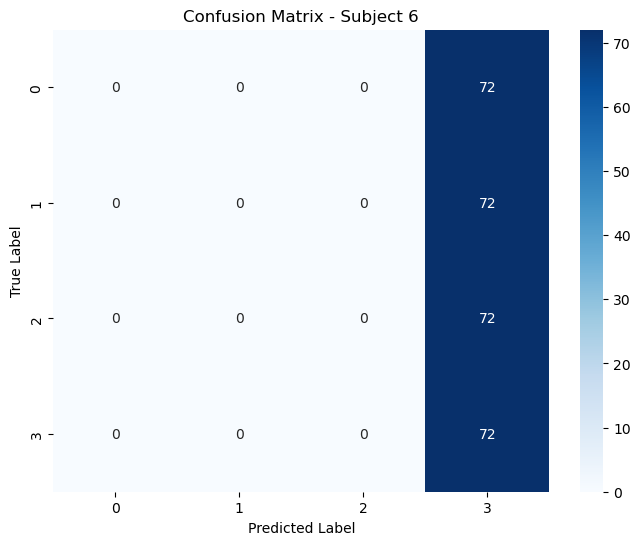


=== Training on Subject 7/9 ===
Epoch [1/350], Step [1/9], Loss: 1.5570


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Train Loss: 1.5622, Val Loss: 1.3937
Early stopping triggered after 37 epochs.


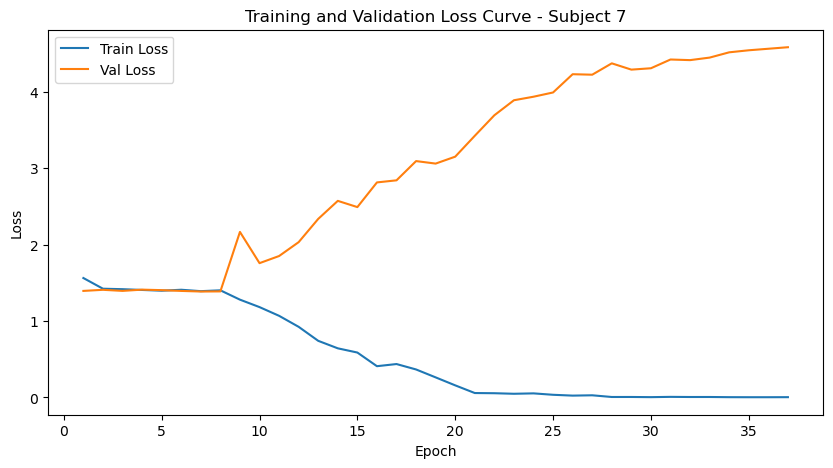

Subject 7 Accuracy: 25.00%
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        72
           1     0.0000    0.0000    0.0000        72
           2     0.2500    1.0000    0.4000        72
           3     0.0000    0.0000    0.0000        72

    accuracy                         0.2500       288
   macro avg     0.0625    0.2500    0.1000       288
weighted avg     0.0625    0.2500    0.1000       288



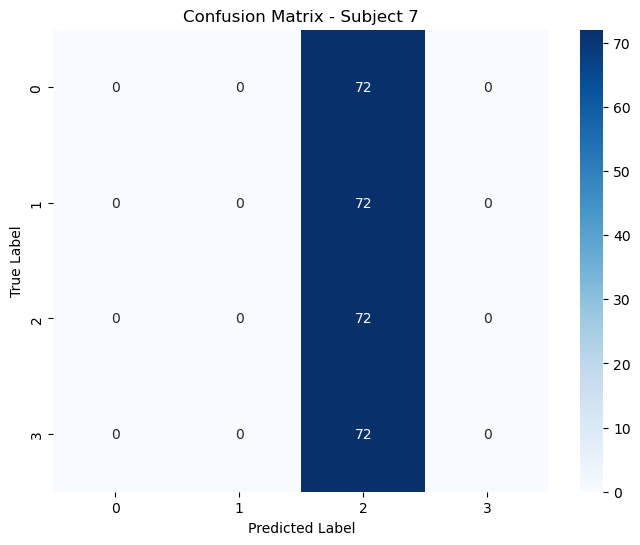


=== Training on Subject 8/9 ===
Epoch [1/350], Step [1/9], Loss: 1.3841


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Train Loss: 1.5781, Val Loss: 1.4977
Early stopping triggered after 33 epochs.


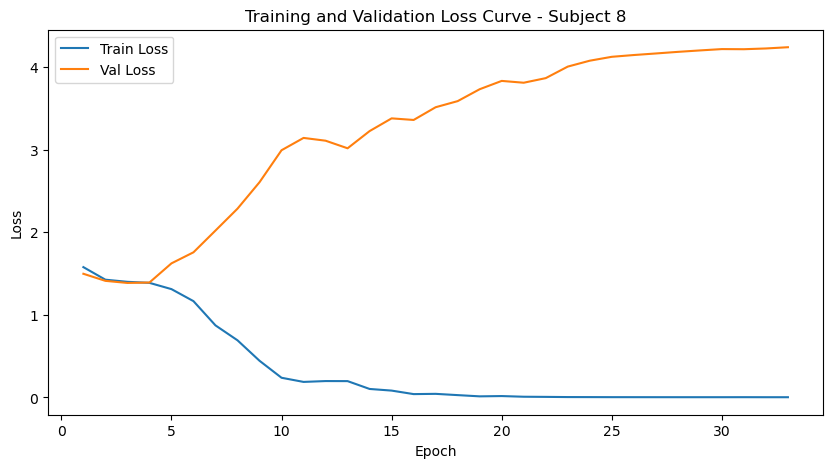

Subject 8 Accuracy: 25.00%
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        72
           1     0.2500    1.0000    0.4000        72
           2     0.0000    0.0000    0.0000        72
           3     0.0000    0.0000    0.0000        72

    accuracy                         0.2500       288
   macro avg     0.0625    0.2500    0.1000       288
weighted avg     0.0625    0.2500    0.1000       288



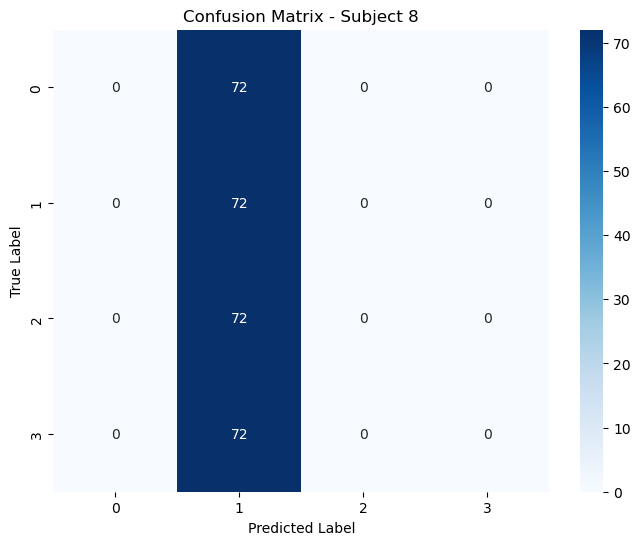


=== Training on Subject 9/9 ===
Epoch [1/350], Step [1/9], Loss: 1.3511


C:\Users\vis_l\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\vis_l\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/350], Train Loss: 1.7608, Val Loss: 1.4260
Early stopping triggered after 33 epochs.


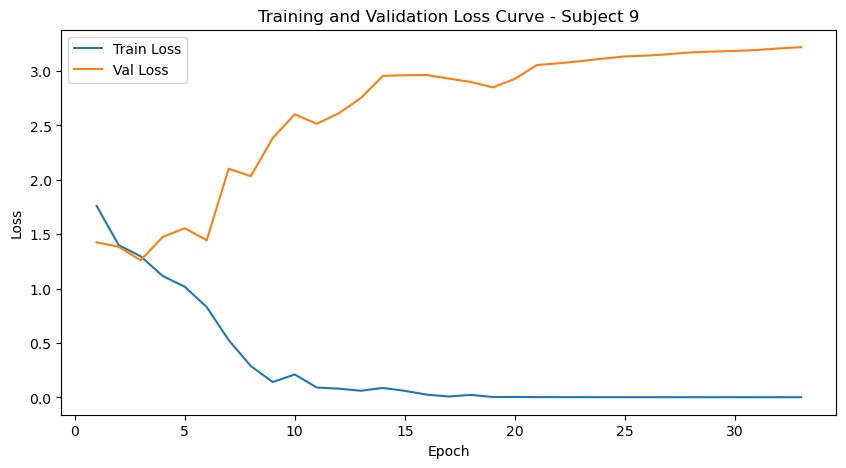

Subject 9 Accuracy: 37.85%
Classification Report:
              precision    recall  f1-score   support

           0     0.4336    0.8611    0.5767        72
           1     0.2368    0.1250    0.1636        72
           2     0.2535    0.2500    0.2517        72
           3     0.5556    0.2778    0.3704        72

    accuracy                         0.3785       288
   macro avg     0.3699    0.3785    0.3406       288
weighted avg     0.3699    0.3785    0.3406       288



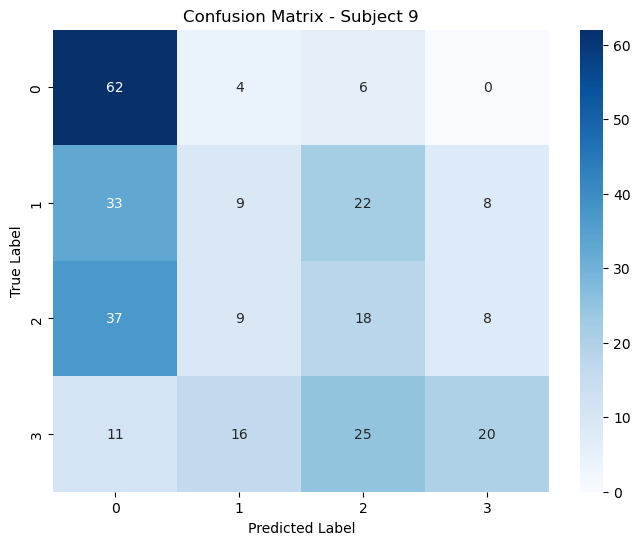


Mean Accuracy across all subjects: 26.77%


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

# Define TransformerEEGNet and PositionalEncoding classes here or import them

# Set random seeds for reproducibility
torch.manual_seed(2003)
np.random.seed(2003)

# Define data paths
data_path = ['A0' + str(i) + j for i in range(1, 10) for j in ['T', 'E']]
# Example: ['A01T', 'A01E', 'A02T', 'A02E', ..., 'A09T', 'A09E']

# Initialize accuracy storage
num_subjects = len(data_path) // 2
accuracy_train = np.zeros((num_subjects, 1))
# accuracy_test = np.zeros((num_subjects, 1))  # Currently not used

# Training parameters
epochs = 350
batch_size = 32
learning_rate = 1e-3
n_classes = 4
channels = 22
samples = 1125

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Early Stopping Parameters
patience = 30  # Number of epochs to wait before stopping if no improvement

# Loop over each subject's dataset
for sub in range(num_subjects):
    print(f"\n=== Training on Subject {sub + 1}/{num_subjects} ===")
    
    # Load training data
    train_data = np.load(f'2a_pre/{data_path[2 * sub]}.npz')
    train_inputs = torch.Tensor(train_data['data'])  # Assuming shape [num_samples, channels, samples]
    train_labels = torch.Tensor(train_data['label']).long() - 1  # Labels adjusted to start from 0
    
    # Load validation data
    val_data = np.load(f'2a_pre/{data_path[2 * sub + 1]}.npz')
    val_inputs = torch.Tensor(val_data['data'])
    val_labels = torch.Tensor(val_data['label']).long() - 1
    
    # Normalize the data (zero mean and unit variance)
    mean = train_inputs.mean(dim=(0, 2), keepdim=True)
    std = train_inputs.std(dim=(0, 2), keepdim=True) + 1e-6  # Add epsilon to avoid division by zero
    train_inputs = (train_inputs - mean) / std
    val_inputs = (val_inputs - mean) / std  # Use training mean and std for validation
    
    # Initialize the Transformer-based model
    model = TransformerEEGNet(
        n_classes=n_classes,
        channels=channels,
        samples=samples,
        d_model=128,           # You can adjust these hyperparameters
        nhead=8,
        num_layers=4,
        dim_feedforward=512,
        dropout=0.3  # Increased dropout for better regularization
    ).to(device)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Using AdamW
    
    # Learning rate scheduler (without verbose)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                     factor=0.5, patience=10, 
                                                     verbose=False, min_lr=1e-6)
    
    # Reshape inputs to [batch_size, 1, channels, samples]
    train_inputs = train_inputs.reshape(-1, 1, channels, samples).to(device)
    val_inputs = val_inputs.reshape(-1, 1, channels, samples).to(device)
    train_labels = train_labels.to(device)
    val_labels = val_labels.to(device)
    
    # Create TensorDatasets and DataLoaders
    train_dataset = TensorDataset(train_inputs, train_labels)
    val_dataset = TensorDataset(val_inputs, val_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Shuffle=False for evaluation
    
    # Initialize lists to store loss values
    train_losses = []
    val_losses = []
    
    # Reset early stopping parameters
    best_val_loss = np.inf
    epochs_no_improve = 0
    best_model_state = None
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for i, (inputs, targets) in enumerate(train_loader):
            # Inputs and targets are already on the correct device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            running_train_loss += loss.item()
            
            # Print progress every 100 epochs and every 10 batches
            if (epoch % 100 == 0) and (i % 10 == 0):
                print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # Calculate average training loss for the epoch
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
        
        # Calculate average validation loss for the epoch
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Step the scheduler
        scheduler.step(avg_val_loss)
        
        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs.')
                break
        
        # Optionally, print epoch summary
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Evaluation after training
    model.eval()
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curve - Subject {sub + 1}')
    plt.legend()
    plt.show()
    
    # Calculate confusion matrix and accuracy
    cm = confusion_matrix(all_targets, all_predictions)
    accuracy = np.trace(cm) / np.sum(cm)
    accuracy_train[sub] = accuracy
    print(f'Subject {sub + 1} Accuracy: {accuracy * 100:.2f}%')
    
    # Detailed classification report
    print("Classification Report:")
    print(classification_report(all_targets, all_predictions, digits=4, zero_division=0))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(n_classes), yticklabels=range(n_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - Subject {sub + 1}')
    plt.show()
    
    # Optionally, save the model for each subject
    # torch.save(model.state_dict(), f"TransformerEEGNet_subject_{sub + 1}.pth")

# Calculate and print mean accuracy across all subjects
mean_accuracy_train = np.mean(accuracy_train) * 100
print(f'\nMean Accuracy across all subjects: {mean_accuracy_train:.2f}%')
